<a href="https://colab.research.google.com/github/vicente-gonzalez-ruiz/learned_image_compression/blob/main/LIC2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Simple AutoEncoder (no convolutional layers)
# https://blog.keras.io/building-autoencoders-in-keras.html
# https://www.youtube.com/watch?v=wECwVBmPH7w

# Learned Image Compression (LIC) using [(Compressive) Autoencoders](https://www.lherranz.org/2022/08/24/neural-image-compression-in-a-nutshell-part-1-main-idea/)

An autoencoder consists of two main components: the encoder and the decoder.
The encoder is a function
\begin{equation}
e(\mathbf{X})=\mathbf{Z},
\end{equation}
that maps the input data $X$ to the encoded representation in the latent space $\mathbf{Z}$. The decoder is the inverse function
\begin{equation}
d(\mathbf{Z})=(\mathbf{X}),
\end{equation}
that maps the encoded representation back to the original input space. When an autoencoder is implemented using ANNs (with parameters $\psi=(\theta,\phi)$, where $\theta$ are the parameters of the encoder, and $\phi$ are the parameters of the decoder), and the dimension (the number of elements) of the latent space (the output of the smaller hidden layer) is smaller than the dimension of the input (and output) space, it is impossible to decode the original $\mathbf{X}$, but only one an approximation $\hat{\mathbf{X}}(\psi)$. For this reason, the cost function $J$ optimized (minimized) in an autoencoder is the MSE, defined in this case as
\begin{equation}
D(\mathbf{X}, \hat{\mathbf{X}})=\frac{1}{N}\sum_{i}^{N}(\mathbf{X}_i-\hat{\mathbf{X}}_i)^2,
\end{equation}
where $N$ is the dimension of $\mathbf{X}$ (and $\hat{\mathbf{X}}$), and $\mathbf{X}_i$ is the $i$-th element of $\mathbf{X}$.

Therefore, we can formally define an autoencoder as finding the optimal autoencoder parameters
\begin{equation}
\psi^*=\min_\psi D(\mathbf{X}, \hat{\mathbf{X}}(\psi)).
\end{equation}

In a compressive autoencoder, we also take into consideration the number of bits $R(\mathbf{Z})$ required to represent $\mathbf{Z}$, that we want also to minimize. Therefore, in this case the cost function is defined as the Lagrangian
\begin{equation}
J(\mathbf{X}, \hat{\mathbf{X}}(\psi); \lambda)=D(\mathbf{X}, \hat{\mathbf{X}}) + \lambda R(\mathbf{Z}),
\end{equation}
where $\lambda$ is a hyper-parameter, and we optimize
\begin{equation}
\psi^*=\min_\psi J(\mathbf{X}, \hat{\mathbf{X}}(\psi); \lambda).
\end{equation}

$\lambda$ determines the trading-off between rate $R$ and distortion $D$. If $\lambda$ is big we are priorizing (minimizing) $R$ and therefore, we will get a point in the RD-curve with a small bit-rate (high MSE). On the contrary, if $\lambda$ is small we are minimizing $D$ and therefore, we will be in a point of the RD-curve with a high bit-rate (small MSE).

$\mathbf{Z}$ is usually compressed with an entropy encoder (notice that this encoder is different to the "feature encoder" or "latent encoder" $e$). When the code-words assigned to the symbols $\mathbf{Z}_i$ depends on the probability distribution of $\mathbf{Z}$, such probabilities $p_\psi(\mathbf{Z})$ can be also optimized, where now $\psi=(\theta,\phi, \nu)$.

Finally, notice that we are not constrained to use the MSE as the distortion metric. Other metrics such as the SSIM (more representative of how humans perceive the differences between two images) could be also used.

## About $\mathbf{X}$ and computing resources
For reasons of space and speed, we use the [MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database), that is composed of 70K images of hand written decimal digits. Notice that with this dataset, all the images have the same shape (28x28 pixels), and are monochromatic (8 bits/pixel). We will use [Keras](https://blog.keras.io/building-autoencoders-in-keras.html) (see https://www.tensorflow.org/guide/basics).

## 1. Using 1 hidden layer and no quantization of the latent space
The most basic autoencoder has only one Full-Connected hidden-Layer (FCL) of neurons. Compression is achieved when the output of the hidden neurons (the latent space) requires less bits to be represented than the original image. In this example, the hiddent layer has 32 neurons:

    Input -> FCL -> Output
    28x28    32     28x28

2.14.0
11490434/11490434 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 32)                25120     
                                                                 
 dense_1 (Dense)             (None, 784)               25872     
                                                                 
Total params: 50992 (199.19 KB)
Trainable params: 50992 (199.19 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
157/157 [==============================] - 2s 9ms/step
type latent <class 'numpy.ndarray'>
157/157 [==============================] - 2s 9ms/step
<class 'numpy.ndarray'>


<Figure size 640x480 with 0 Axes>

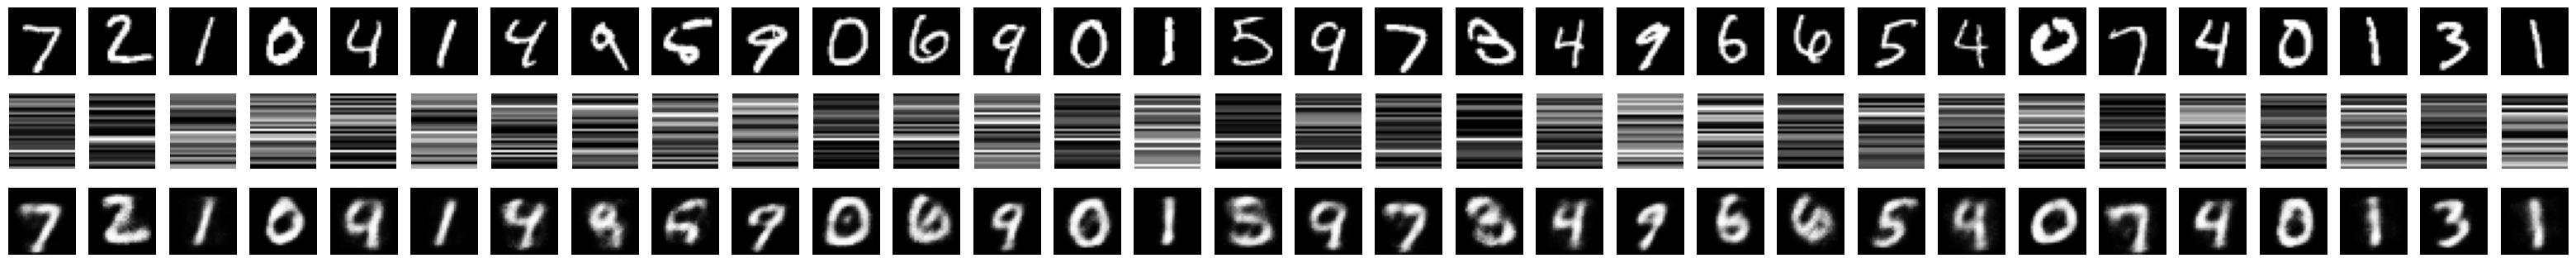

157/157 [==============================] - 1s 8ms/step
type latent <class 'numpy.ndarray'>
157/157 [==============================] - 1s 5ms/step
<class 'numpy.ndarray'>


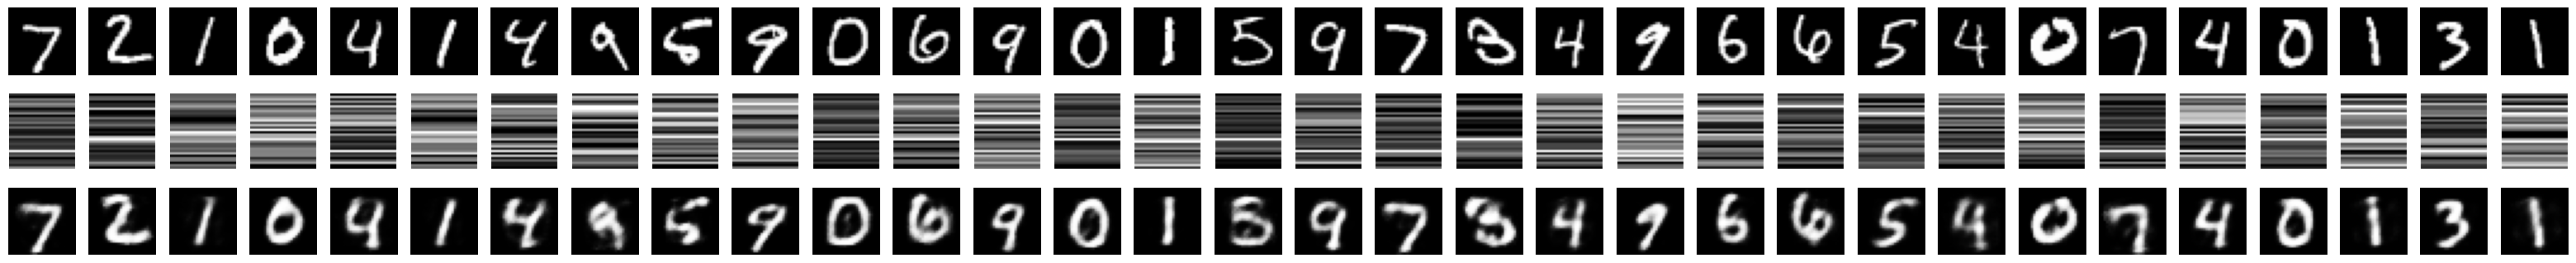

157/157 [==============================] - 1s 4ms/step
type latent <class 'numpy.ndarray'>
157/157 [==============================] - 1s 5ms/step
<class 'numpy.ndarray'>


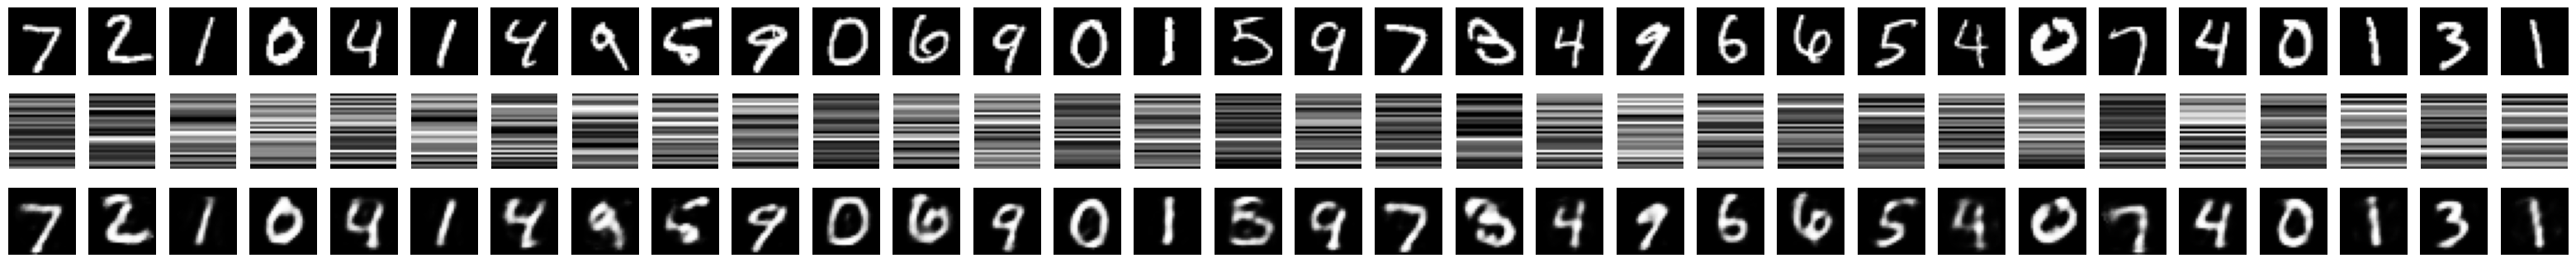

157/157 [==============================] - 1s 7ms/step
type latent <class 'numpy.ndarray'>
157/157 [==============================] - 1s 8ms/step
<class 'numpy.ndarray'>


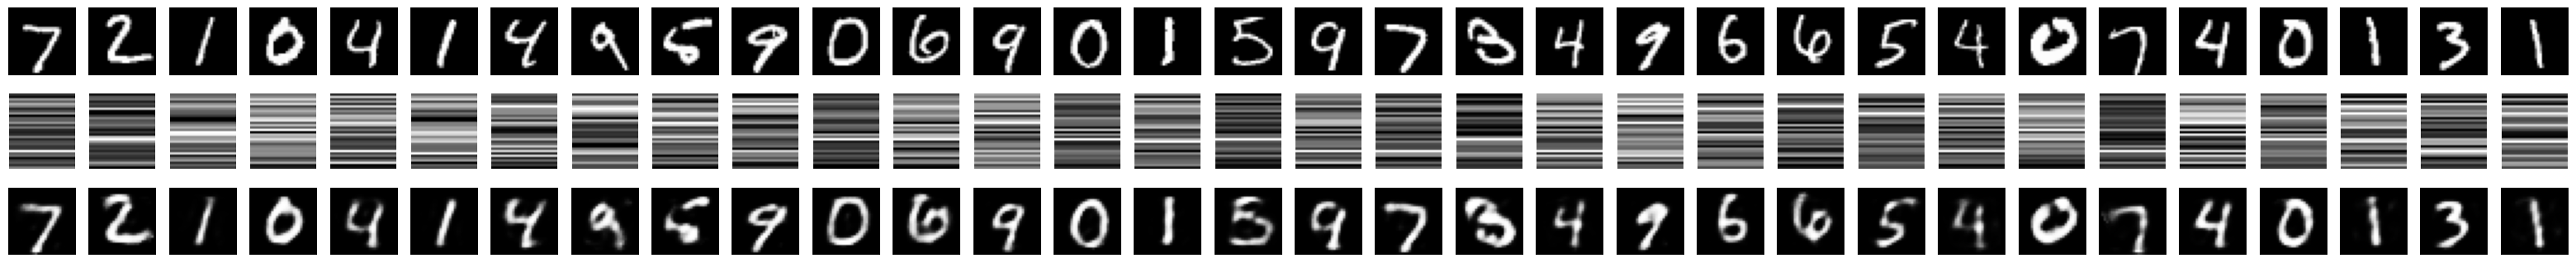

157/157 [==============================] - 1s 5ms/step
type latent <class 'numpy.ndarray'>
157/157 [==============================] - 1s 5ms/step
<class 'numpy.ndarray'>


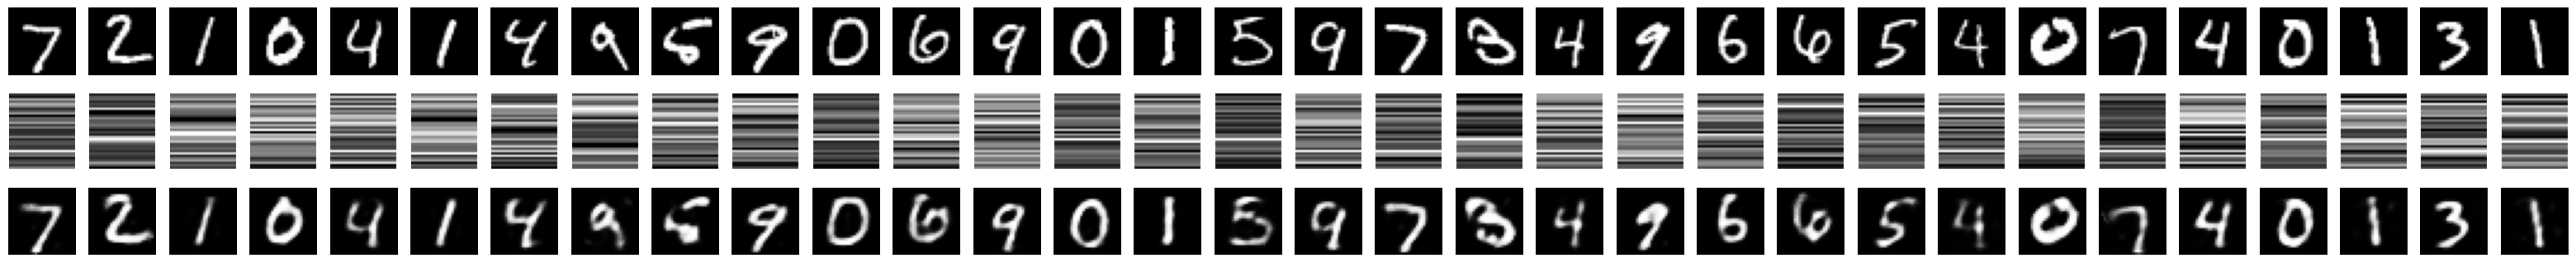

In [ ]:
# Autoencoding example (feeding tf.data.Dataset with NumPy arrays, iterative)

import keras
from keras import layers
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from keras.utils import Sequence
from skimage.io import imread
import math
from sklearn.model_selection import train_test_split
from skimage.transform import resize

print(tf.__version__)

# https://www.tensorflow.org/datasets/catalog/
DATASET = 'mnist'
#DATASET = 'fashion_mnist'
#URL = "https://github.com/zalandoresearch/fashion-mnist/blob/master/data/fashion/train-images-idx3-ubyte.gz"

LATENT_SPACE_LENGTH = 32

img_width = 28
img_height = 28
img_length = img_height * img_width

# Generate the NumPy arrays with the data.
DATA_URL = f'https://storage.googleapis.com/tensorflow/tf-keras-datasets/{DATASET}.npz'
path = tf.keras.utils.get_file(f'{DATASET}.npz', DATA_URL)
with np.load(path) as data:
    x_train = data['x_train']
    y_train = data['x_train']
    x_test = data['x_test']
    y_test = data['x_test']

# Generate the pipelines.
train_DS = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_DS = tf.data.Dataset.from_tensor_slices((x_test, y_test))

# Define how to use the datasets, preprocess, etc.

def process_x(image, label):
    processed_img = tf.reshape(image, (img_height * img_width, 1))
    processed_img = tf.cast(processed_img, tf.float32) / 255.
    return processed_img, label

def process_y(image, label):
    # The last layer of the network is a dense layer and TensorFlow imposes 1D.
    return image, tf.reshape(image, (img_height * img_width, 1))

BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100
train_DS = train_DS.map(process_x)
train_DS = train_DS.map(process_y)
train_DS = train_DS.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_DS = test_DS.map(process_x)
test_DS = test_DS.map(process_y)
test_DS = test_DS.batch(BATCH_SIZE)

# Define the autoencoder.
input_layer = keras.Input(
    shape=(img_length,))
hidden_layer = layers.Dense(
    LATENT_SPACE_LENGTH,
    activation="relu")(input_layer)
output_layer = layers.Dense(
    img_length,
    activation="sigmoid")(hidden_layer)

autoencoder = keras.Model(
    input_layer,
    output_layer)

# To see the latents (content of the hidden layer), we define a new "model" with only the encoder.
encoder = keras.Model(
    input_layer,
    hidden_layer)

autoencoder.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss="binary_crossentropy"
)

autoencoder.summary()

# Train.
EPOCHS = 1
ITERATIONS = 5
plt.gray()
for i in range(ITERATIONS):

    autoencoder.fit(
        train_DS,
        epochs=EPOCHS,
        validation_data=test_DS)

    # Show the learning.
    plt.figure(figsize=(40,4))

    n = len(train_DS)
    if n > 32:
        n = 32

    # Show the originals (using the pipeline).
    for images in test_DS.take(1):
        for i in range(n):
            ax = plt.subplot(3, n, i + 1)
            try:
                image = images[0][i].numpy()
                image *= 255
                image = image.astype("uint8").reshape(img_height, img_width)
                plt.imshow(image)
                #plt.gray()
                plt.axis("off")
            except:
                pass

    # See the latent space (as images).
    latent_imgs = encoder.predict(test_DS)
    print("type latent", type(latent_imgs))
    for i in range(n):
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(resize(latent_imgs[i],(LATENT_SPACE_LENGTH, img_width)))
        plt.axis("off")

    # See the reconstructions.
    reconstructed_imgs = autoencoder.predict(test_DS)
    print(type(reconstructed_imgs))
    for i in range(n):
        ax = plt.subplot(3, n, i + 1 + 2*n)
        plt.imshow(reconstructed_imgs[i].reshape(img_height, img_width))
        plt.axis("off")

    plt.show()

Notice that we have found a lossy compact representation of 28x28 scalars (integers) using only 32 (floats) scalars.

##  2. Quantizing the latent space
Usually, floating points numbers requires at least 32 bits, which reduces the compression ratio. For this reason, we add a new custom layer that quantizes the latent space.

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 784)]             0         
                                                                 
 dense_4 (Dense)             (None, 32)                25120     
                                                                 
 quantization (Quantization  (None, 32)                0         
 _8bits)                                                         
                                                                 
 outputs (Dense)             (None, 784)               25872     
                                                                 
Total params: 50992 (199.19 KB)
Trainable params: 50992 (199.19 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


 1/59 [..............................] - ETA: 21s - loss: 0.6930

 2/59 [>.............................] - ETA: 9s - loss: 0.6920 

 3/59 [>.............................] - ETA: 10s - loss: 0.6911

 4/59 [=>............................] - ETA: 9s - loss: 0.6901 

 5/59 [=>............................] - ETA: 8s - loss: 0.6891

 6/59 [==>...........................] - ETA: 9s - loss: 0.6881

 7/59 [==>...........................] - ETA: 9s - loss: 0.6872

 8/59 [===>..........................] - ETA: 9s - loss: 0.6862

 9/59 [===>..........................] - ETA: 8s - loss: 0.6852

10/59 [====>.........................] - ETA: 8s - loss: 0.6843

11/59 [====>.........................] - ETA: 8s - loss: 0.6833

12/59 [=====>........................] - ETA: 8s - loss: 0.6823

13/59 [=====>........................] - ETA: 8s - loss: 0.6814

14/59 [======>.......................] - ETA: 8s - loss: 0.6805

15/59 [======>.......................] - ETA: 7s - loss: 0.6795

16/59 [=======>......................] - ETA: 7s - loss: 0.6785

17/59 [=======>......................] - ETA: 7s - loss: 0.6776

18/59 [========>.....................] - ETA: 7s - loss: 0.6766

19/59 [========>.....................] - ETA: 6s - loss: 0.6756

20/59 [=========>....................] - ETA: 6s - loss: 0.6747

21/59 [=========>....................] - ETA: 6s - loss: 0.6737

22/59 [==========>...................] - ETA: 6s - loss: 0.6728

23/59 [==========>...................] - ETA: 6s - loss: 0.6719

24/59 [===========>..................] - ETA: 6s - loss: 0.6710

25/59 [===========>..................] - ETA: 5s - loss: 0.6700

26/59 [============>.................] - ETA: 5s - loss: 0.6690

27/59 [============>.................] - ETA: 5s - loss: 0.6681

28/59 [=============>................] - ETA: 5s - loss: 0.6671

29/59 [=============>................] - ETA: 5s - loss: 0.6662

30/59 [==============>...............] - ETA: 5s - loss: 0.6653

31/59 [==============>...............] - ETA: 5s - loss: 0.6644

32/59 [===============>..............] - ETA: 4s - loss: 0.6635

33/59 [===============>..............] - ETA: 4s - loss: 0.6626

34/59 [================>.............] - ETA: 4s - loss: 0.6616

35/59 [================>.............] - ETA: 4s - loss: 0.6608

36/59 [=================>............] - ETA: 4s - loss: 0.6599

37/59 [=================>............] - ETA: 3s - loss: 0.6590

38/59 [==================>...........] - ETA: 3s - loss: 0.6581

39/59 [==================>...........] - ETA: 3s - loss: 0.6572

40/59 [===================>..........] - ETA: 3s - loss: 0.6563

41/59 [===================>..........] - ETA: 3s - loss: 0.6554

42/59 [====================>.........] - ETA: 3s - loss: 0.6546

43/59 [====================>.........] - ETA: 2s - loss: 0.6537

44/59 [=====================>........] - ETA: 2s - loss: 0.6528

45/59 [=====================>........] - ETA: 2s - loss: 0.6519

46/59 [======================>.......] - ETA: 2s - loss: 0.6510

47/59 [======================>.......] - ETA: 2s - loss: 0.6501

48/59 [=======================>......] - ETA: 1s - loss: 0.6493

49/59 [=======================>......] - ETA: 1s - loss: 0.6484

50/59 [========================>.....] - ETA: 1s - loss: 0.6475

51/59 [========================>.....] - ETA: 1s - loss: 0.6467

52/59 [=========================>....] - ETA: 1s - loss: 0.6458

53/59 [=========================>....] - ETA: 1s - loss: 0.6450

54/59 [==========================>...] - ETA: 0s - loss: 0.6441

55/59 [==========================>...] - ETA: 0s - loss: 0.6432

56/59 [===========================>..] - ETA: 0s - loss: 0.6424

57/59 [===========================>..] - ETA: 0s - loss: 0.6415

58/59 [============================>.] - ETA: 0s - loss: 0.6407

59/59 [==============================] - 12s 205ms/step - loss: 0.6402 - val_loss: 0.5891
batch_vals = tf.Tensor(
[[  0   0  65 ... 127  42   0]
 [  0   0  58 ...   0   5   0]
 [  0   0 127 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0 127 ...  18   4   0]
 [  0   0   0 ...   0   0   0]], shape=(784, 32), dtype=int8)
4.995091034128912
4.996139667487098
4.9956003884022895
4.994715855790009
4.994393981853039
4.993264478397924
4.995714589907269
4.9940944928284505
4.994409987285803
4.9949115509053374
4.996159685918233
4.997419307344548
10/10 [==============================] - 0s 41ms/step
type latent <class 'numpy.ndarray'>
10/10 [==============================] - 0s 45ms/step
<class 'numpy.ndarray'>


<Figure size 640x480 with 0 Axes>

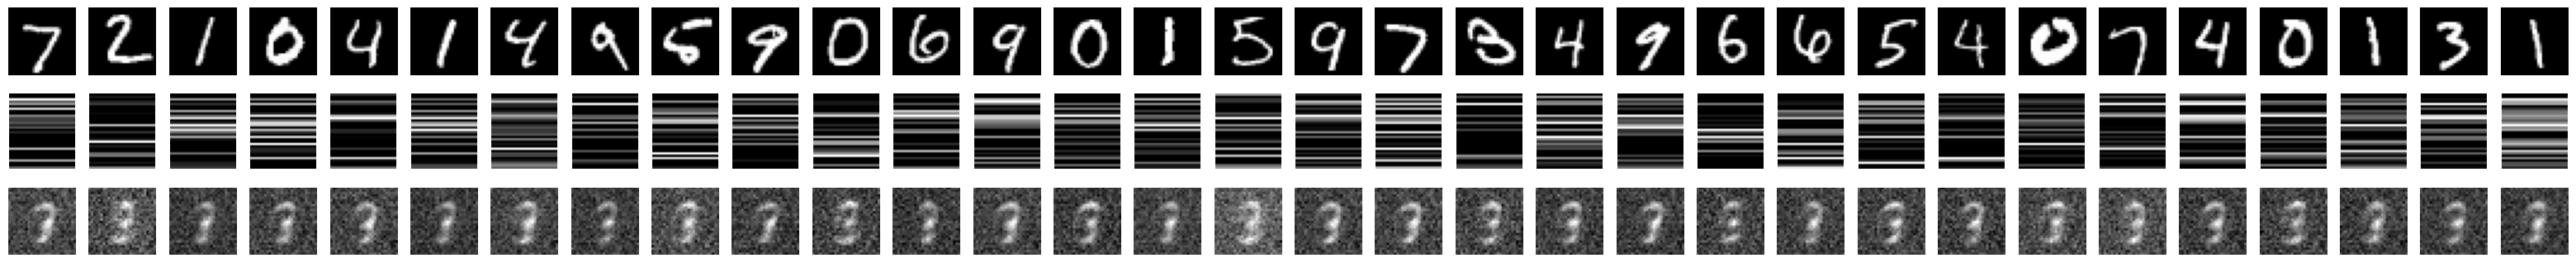

 1/59 [..............................] - ETA: 10s - loss: 0.5908

 2/59 [>.............................] - ETA: 5s - loss: 0.5897 

 3/59 [>.............................] - ETA: 6s - loss: 0.5887

 4/59 [=>............................] - ETA: 5s - loss: 0.5877

 5/59 [=>............................] - ETA: 5s - loss: 0.5868

 6/59 [==>...........................] - ETA: 5s - loss: 0.5864

 7/59 [==>...........................] - ETA: 5s - loss: 0.5856

 8/59 [===>..........................] - ETA: 5s - loss: 0.5848

 9/59 [===>..........................] - ETA: 5s - loss: 0.5840

10/59 [====>.........................] - ETA: 5s - loss: 0.5833

11/59 [====>.........................] - ETA: 5s - loss: 0.5826

12/59 [=====>........................] - ETA: 5s - loss: 0.5818

13/59 [=====>........................] - ETA: 5s - loss: 0.5812

14/59 [======>.......................] - ETA: 4s - loss: 0.5806

15/59 [======>.......................] - ETA: 4s - loss: 0.5798

16/59 [=======>......................] - ETA: 4s - loss: 0.5791

17/59 [=======>......................] - ETA: 4s - loss: 0.5783

18/59 [========>.....................] - ETA: 4s - loss: 0.5774

19/59 [========>.....................] - ETA: 4s - loss: 0.5767

20/59 [=========>....................] - ETA: 4s - loss: 0.5760

21/59 [=========>....................] - ETA: 4s - loss: 0.5753

22/59 [==========>...................] - ETA: 4s - loss: 0.5746

23/59 [==========>...................] - ETA: 3s - loss: 0.5740

24/59 [===========>..................] - ETA: 3s - loss: 0.5733

25/59 [===========>..................] - ETA: 3s - loss: 0.5725

26/59 [============>.................] - ETA: 3s - loss: 0.5716

27/59 [============>.................] - ETA: 3s - loss: 0.5709

28/59 [=============>................] - ETA: 3s - loss: 0.5702

29/59 [=============>................] - ETA: 3s - loss: 0.5696

30/59 [==============>...............] - ETA: 3s - loss: 0.5689

31/59 [==============>...............] - ETA: 3s - loss: 0.5682

32/59 [===============>..............] - ETA: 2s - loss: 0.5675

33/59 [===============>..............] - ETA: 2s - loss: 0.5668

34/59 [================>.............] - ETA: 2s - loss: 0.5661

35/59 [================>.............] - ETA: 2s - loss: 0.5655

36/59 [=================>............] - ETA: 2s - loss: 0.5648

37/59 [=================>............] - ETA: 2s - loss: 0.5642

38/59 [==================>...........] - ETA: 2s - loss: 0.5635

39/59 [==================>...........] - ETA: 2s - loss: 0.5628

40/59 [===================>..........] - ETA: 2s - loss: 0.5622

41/59 [===================>..........] - ETA: 1s - loss: 0.5616

42/59 [====================>.........] - ETA: 1s - loss: 0.5610

43/59 [====================>.........] - ETA: 1s - loss: 0.5603

44/59 [=====================>........] - ETA: 1s - loss: 0.5596

45/59 [=====================>........] - ETA: 1s - loss: 0.5590

46/59 [======================>.......] - ETA: 1s - loss: 0.5583

47/59 [======================>.......] - ETA: 1s - loss: 0.5576

48/59 [=======================>......] - ETA: 1s - loss: 0.5570

49/59 [=======================>......] - ETA: 1s - loss: 0.5564

50/59 [========================>.....] - ETA: 0s - loss: 0.5557

51/59 [========================>.....] - ETA: 0s - loss: 0.5551

52/59 [=========================>....] - ETA: 0s - loss: 0.5544

53/59 [=========================>....] - ETA: 0s - loss: 0.5538

54/59 [==========================>...] - ETA: 0s - loss: 0.5531

55/59 [==========================>...] - ETA: 0s - loss: 0.5525

56/59 [===========================>..] - ETA: 0s - loss: 0.5518

57/59 [===========================>..] - ETA: 0s - loss: 0.5512

58/59 [============================>.] - ETA: 0s - loss: 0.5506

59/59 [==============================] - 8s 132ms/step - loss: 0.5503 - val_loss: 0.5120
batch_vals = tf.Tensor(
[[  0   0  65 ... 127  42   0]
 [  0   0  58 ...   0   5   0]
 [  0   0 127 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0 127 ...  18   4   0]
 [  0   0   0 ...   0   0   0]], shape=(784, 32), dtype=int8)
4.995091034128912
4.996139667487098
4.9956003884022895
4.994715855790009
4.994393981853039
4.993264478397924
4.995714589907269
4.9940944928284505
4.994409987285803
4.9949115509053374
4.996159685918233
4.997419307344548
10/10 [==============================] - 1s 63ms/step
type latent <class 'numpy.ndarray'>
10/10 [==============================] - 1s 54ms/step
<class 'numpy.ndarray'>


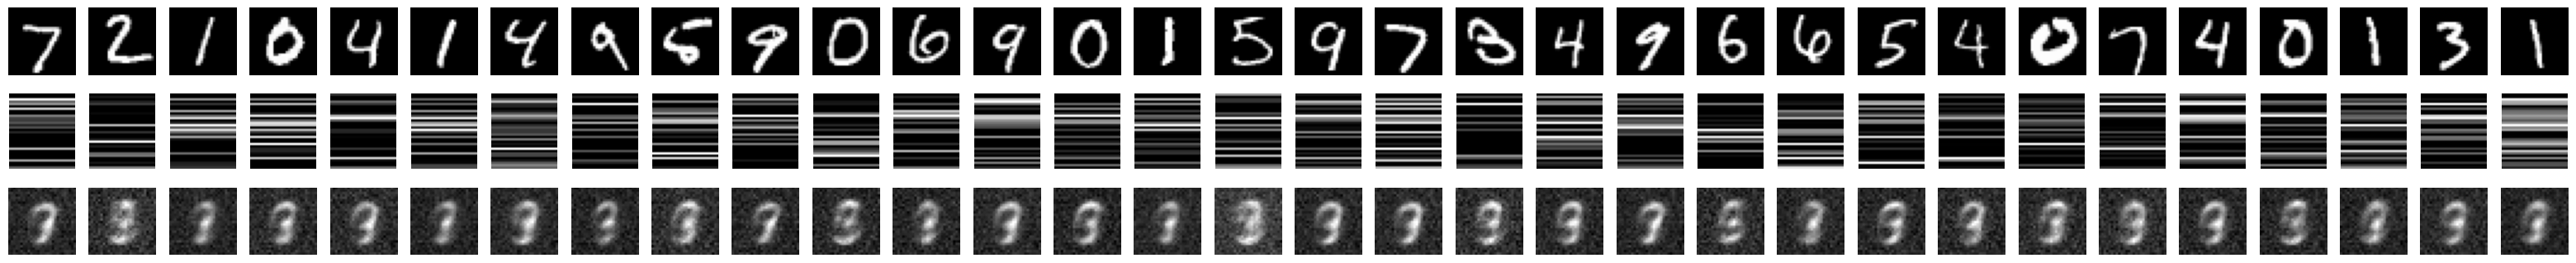

 1/59 [..............................] - ETA: 11s - loss: 0.5146

 2/59 [>.............................] - ETA: 6s - loss: 0.5133 

 3/59 [>.............................] - ETA: 6s - loss: 0.5126

 4/59 [=>............................] - ETA: 6s - loss: 0.5116

 5/59 [=>............................] - ETA: 6s - loss: 0.5109

 6/59 [==>...........................] - ETA: 6s - loss: 0.5108

 7/59 [==>...........................] - ETA: 6s - loss: 0.5102

 8/59 [===>..........................] - ETA: 6s - loss: 0.5095

 9/59 [===>..........................] - ETA: 5s - loss: 0.5090

10/59 [====>.........................] - ETA: 5s - loss: 0.5084

11/59 [====>.........................] - ETA: 5s - loss: 0.5079

12/59 [=====>........................] - ETA: 5s - loss: 0.5072

13/59 [=====>........................] - ETA: 5s - loss: 0.5070

14/59 [======>.......................] - ETA: 5s - loss: 0.5066

15/59 [======>.......................] - ETA: 5s - loss: 0.5060

16/59 [=======>......................] - ETA: 5s - loss: 0.5055

17/59 [=======>......................] - ETA: 4s - loss: 0.5049

18/59 [========>.....................] - ETA: 4s - loss: 0.5041

19/59 [========>.....................] - ETA: 4s - loss: 0.5035

20/59 [=========>....................] - ETA: 4s - loss: 0.5031

21/59 [=========>....................] - ETA: 4s - loss: 0.5025

22/59 [==========>...................] - ETA: 4s - loss: 0.5020

23/59 [==========>...................] - ETA: 4s - loss: 0.5016

24/59 [===========>..................] - ETA: 4s - loss: 0.5010

25/59 [===========>..................] - ETA: 4s - loss: 0.5005

26/59 [============>.................] - ETA: 3s - loss: 0.4997

27/59 [============>.................] - ETA: 3s - loss: 0.4991

28/59 [=============>................] - ETA: 3s - loss: 0.4986

29/59 [=============>................] - ETA: 3s - loss: 0.4982

30/59 [==============>...............] - ETA: 3s - loss: 0.4976

31/59 [==============>...............] - ETA: 3s - loss: 0.4971

32/59 [===============>..............] - ETA: 3s - loss: 0.4966

33/59 [===============>..............] - ETA: 3s - loss: 0.4960

34/59 [================>.............] - ETA: 3s - loss: 0.4955

35/59 [================>.............] - ETA: 2s - loss: 0.4951

36/59 [=================>............] - ETA: 2s - loss: 0.4947

37/59 [=================>............] - ETA: 2s - loss: 0.4942

38/59 [==================>...........] - ETA: 2s - loss: 0.4937

39/59 [==================>...........] - ETA: 2s - loss: 0.4932

40/59 [===================>..........] - ETA: 2s - loss: 0.4927

41/59 [===================>..........] - ETA: 2s - loss: 0.4923

42/59 [====================>.........] - ETA: 2s - loss: 0.4919

43/59 [====================>.........] - ETA: 1s - loss: 0.4914

44/59 [=====================>........] - ETA: 1s - loss: 0.4909

45/59 [=====================>........] - ETA: 1s - loss: 0.4904

46/59 [======================>.......] - ETA: 1s - loss: 0.4898

47/59 [======================>.......] - ETA: 1s - loss: 0.4894

48/59 [=======================>......] - ETA: 1s - loss: 0.4889

49/59 [=======================>......] - ETA: 1s - loss: 0.4884

50/59 [========================>.....] - ETA: 1s - loss: 0.4879

51/59 [========================>.....] - ETA: 0s - loss: 0.4875

52/59 [=========================>....] - ETA: 0s - loss: 0.4870

53/59 [=========================>....] - ETA: 0s - loss: 0.4865

54/59 [==========================>...] - ETA: 0s - loss: 0.4860

55/59 [==========================>...] - ETA: 0s - loss: 0.4855

56/59 [===========================>..] - ETA: 0s - loss: 0.4850

57/59 [===========================>..] - ETA: 0s - loss: 0.4845

58/59 [============================>.] - ETA: 0s - loss: 0.4842

59/59 [==============================] - 9s 143ms/step - loss: 0.4839 - val_loss: 0.4551
batch_vals = tf.Tensor(
[[  0   0  65 ... 127  42   0]
 [  0   0  58 ...   0   5   0]
 [  0   0 127 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0 127 ...  18   4   0]
 [  0   0   0 ...   0   0   0]], shape=(784, 32), dtype=int8)
4.995091034128912
4.996139667487098
4.9956003884022895
4.994715855790009
4.994393981853039
4.993264478397924
4.995714589907269
4.9940944928284505
4.994409987285803
4.9949115509053374
4.996159685918233
4.997419307344548
10/10 [==============================] - 0s 45ms/step
type latent <class 'numpy.ndarray'>
10/10 [==============================] - 1s 53ms/step
<class 'numpy.ndarray'>


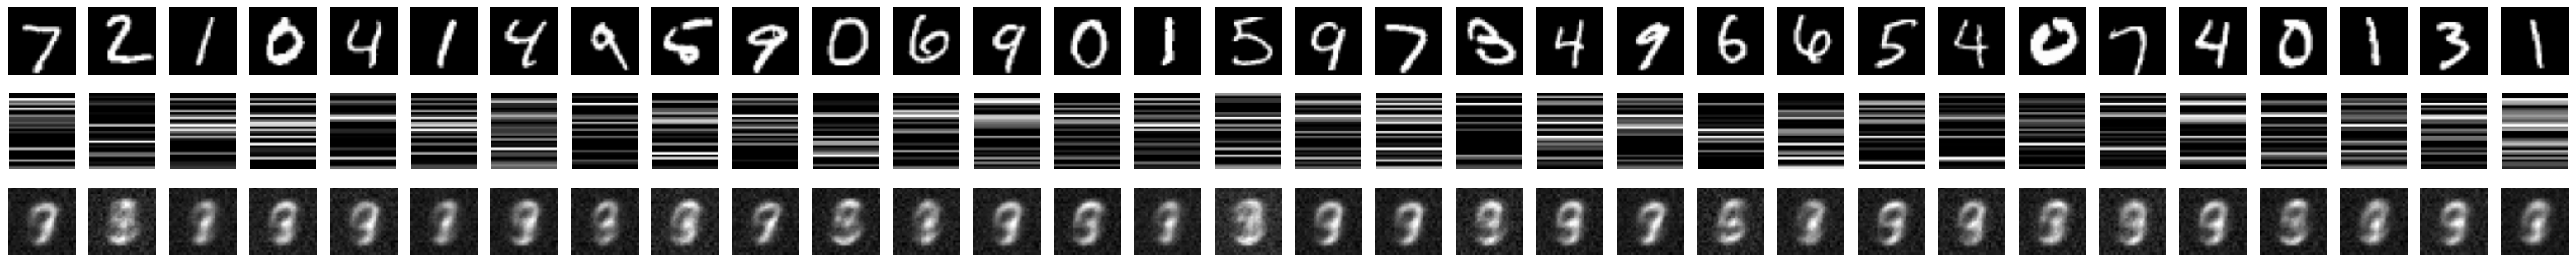

 1/59 [..............................] - ETA: 11s - loss: 0.4582

 2/59 [>.............................] - ETA: 6s - loss: 0.4569 

 3/59 [>.............................] - ETA: 6s - loss: 0.4561

 4/59 [=>............................] - ETA: 7s - loss: 0.4553

 5/59 [=>............................] - ETA: 6s - loss: 0.4548

 6/59 [==>...........................] - ETA: 6s - loss: 0.4550

 7/59 [==>...........................] - ETA: 6s - loss: 0.4543

 8/59 [===>..........................] - ETA: 6s - loss: 0.4538

 9/59 [===>..........................] - ETA: 6s - loss: 0.4534

10/59 [====>.........................] - ETA: 6s - loss: 0.4530

11/59 [====>.........................] - ETA: 6s - loss: 0.4527

12/59 [=====>........................] - ETA: 6s - loss: 0.4520

13/59 [=====>........................] - ETA: 5s - loss: 0.4521

14/59 [======>.......................] - ETA: 5s - loss: 0.4518

15/59 [======>.......................] - ETA: 5s - loss: 0.4514

16/59 [=======>......................] - ETA: 5s - loss: 0.4510

17/59 [=======>......................] - ETA: 5s - loss: 0.4505

18/59 [========>.....................] - ETA: 5s - loss: 0.4498

19/59 [========>.....................] - ETA: 5s - loss: 0.4493

20/59 [=========>....................] - ETA: 5s - loss: 0.4490

21/59 [=========>....................] - ETA: 4s - loss: 0.4486

22/59 [==========>...................] - ETA: 4s - loss: 0.4482

23/59 [==========>...................] - ETA: 4s - loss: 0.4480

24/59 [===========>..................] - ETA: 4s - loss: 0.4476

25/59 [===========>..................] - ETA: 4s - loss: 0.4471

26/59 [============>.................] - ETA: 4s - loss: 0.4464

27/59 [============>.................] - ETA: 4s - loss: 0.4460

28/59 [=============>................] - ETA: 3s - loss: 0.4456

29/59 [=============>................] - ETA: 3s - loss: 0.4453

30/59 [==============>...............] - ETA: 3s - loss: 0.4449

31/59 [==============>...............] - ETA: 3s - loss: 0.4445

32/59 [===============>..............] - ETA: 3s - loss: 0.4441

33/59 [===============>..............] - ETA: 3s - loss: 0.4436

34/59 [================>.............] - ETA: 3s - loss: 0.4433

35/59 [================>.............] - ETA: 3s - loss: 0.4429

36/59 [=================>............] - ETA: 3s - loss: 0.4427

37/59 [=================>............] - ETA: 2s - loss: 0.4423

38/59 [==================>...........] - ETA: 2s - loss: 0.4419

39/59 [==================>...........] - ETA: 2s - loss: 0.4416

40/59 [===================>..........] - ETA: 2s - loss: 0.4412

41/59 [===================>..........] - ETA: 2s - loss: 0.4410

42/59 [====================>.........] - ETA: 2s - loss: 0.4406

43/59 [====================>.........] - ETA: 2s - loss: 0.4402

44/59 [=====================>........] - ETA: 2s - loss: 0.4398

45/59 [=====================>........] - ETA: 1s - loss: 0.4394

46/59 [======================>.......] - ETA: 1s - loss: 0.4391

47/59 [======================>.......] - ETA: 1s - loss: 0.4387

48/59 [=======================>......] - ETA: 1s - loss: 0.4384

49/59 [=======================>......] - ETA: 1s - loss: 0.4380

50/59 [========================>.....] - ETA: 1s - loss: 0.4376

51/59 [========================>.....] - ETA: 1s - loss: 0.4373

52/59 [=========================>....] - ETA: 1s - loss: 0.4369

53/59 [=========================>....] - ETA: 0s - loss: 0.4365

54/59 [==========================>...] - ETA: 0s - loss: 0.4361

55/59 [==========================>...] - ETA: 0s - loss: 0.4358

56/59 [===========================>..] - ETA: 0s - loss: 0.4354

57/59 [===========================>..] - ETA: 0s - loss: 0.4350

58/59 [============================>.] - ETA: 0s - loss: 0.4348

59/59 [==============================] - 10s 167ms/step - loss: 0.4346 - val_loss: 0.4125
batch_vals = tf.Tensor(
[[  0   0  65 ... 127  42   0]
 [  0   0  58 ...   0   5   0]
 [  0   0 127 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0 127 ...  18   4   0]
 [  0   0   0 ...   0   0   0]], shape=(784, 32), dtype=int8)
4.995091034128912
4.996139667487098
4.9956003884022895
4.994715855790009
4.994393981853039
4.993264478397924
4.995714589907269
4.9940944928284505
4.994409987285803
4.9949115509053374
4.996159685918233
4.997419307344548
10/10 [==============================] - 1s 53ms/step
type latent <class 'numpy.ndarray'>
10/10 [==============================] - 1s 62ms/step
<class 'numpy.ndarray'>


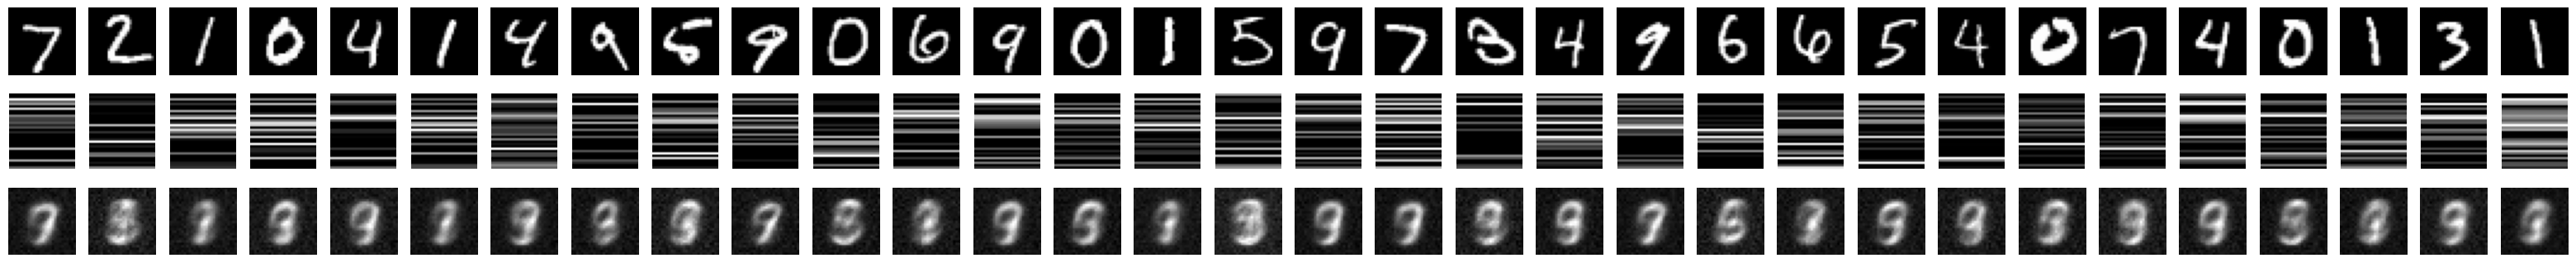

 1/59 [..............................] - ETA: 11s - loss: 0.4153

 2/59 [>.............................] - ETA: 7s - loss: 0.4144 

 3/59 [>.............................] - ETA: 7s - loss: 0.4138

 4/59 [=>............................] - ETA: 7s - loss: 0.4131

 5/59 [=>............................] - ETA: 7s - loss: 0.4127

 6/59 [==>...........................] - ETA: 7s - loss: 0.4131

 7/59 [==>...........................] - ETA: 7s - loss: 0.4126

 8/59 [===>..........................] - ETA: 7s - loss: 0.4121

 9/59 [===>..........................] - ETA: 6s - loss: 0.4118

10/59 [====>.........................] - ETA: 6s - loss: 0.4115

11/59 [====>.........................] - ETA: 6s - loss: 0.4112

12/59 [=====>........................] - ETA: 6s - loss: 0.4107

13/59 [=====>........................] - ETA: 6s - loss: 0.4109

14/59 [======>.......................] - ETA: 6s - loss: 0.4108

15/59 [======>.......................] - ETA: 6s - loss: 0.4105

16/59 [=======>......................] - ETA: 6s - loss: 0.4101

17/59 [=======>......................] - ETA: 5s - loss: 0.4097

18/59 [========>.....................] - ETA: 5s - loss: 0.4090

19/59 [========>.....................] - ETA: 5s - loss: 0.4087

20/59 [=========>....................] - ETA: 5s - loss: 0.4085

21/59 [=========>....................] - ETA: 5s - loss: 0.4082

22/59 [==========>...................] - ETA: 5s - loss: 0.4079

23/59 [==========>...................] - ETA: 4s - loss: 0.4078

24/59 [===========>..................] - ETA: 4s - loss: 0.4075

25/59 [===========>..................] - ETA: 4s - loss: 0.4070

26/59 [============>.................] - ETA: 4s - loss: 0.4064

27/59 [============>.................] - ETA: 4s - loss: 0.4061

28/59 [=============>................] - ETA: 4s - loss: 0.4058

29/59 [=============>................] - ETA: 4s - loss: 0.4056

30/59 [==============>...............] - ETA: 4s - loss: 0.4053

31/59 [==============>...............] - ETA: 3s - loss: 0.4049

32/59 [===============>..............] - ETA: 3s - loss: 0.4046

33/59 [===============>..............] - ETA: 3s - loss: 0.4043

34/59 [================>.............] - ETA: 3s - loss: 0.4040

35/59 [================>.............] - ETA: 3s - loss: 0.4038

36/59 [=================>............] - ETA: 3s - loss: 0.4036

37/59 [=================>............] - ETA: 3s - loss: 0.4033

38/59 [==================>...........] - ETA: 3s - loss: 0.4030

39/59 [==================>...........] - ETA: 2s - loss: 0.4027

40/59 [===================>..........] - ETA: 2s - loss: 0.4025

41/59 [===================>..........] - ETA: 2s - loss: 0.4023

42/59 [====================>.........] - ETA: 2s - loss: 0.4020

43/59 [====================>.........] - ETA: 2s - loss: 0.4017

44/59 [=====================>........] - ETA: 2s - loss: 0.4014

45/59 [=====================>........] - ETA: 2s - loss: 0.4011

46/59 [======================>.......] - ETA: 1s - loss: 0.4008

47/59 [======================>.......] - ETA: 1s - loss: 0.4006

48/59 [=======================>......] - ETA: 1s - loss: 0.4004

49/59 [=======================>......] - ETA: 1s - loss: 0.4001

50/59 [========================>.....] - ETA: 1s - loss: 0.3997

51/59 [========================>.....] - ETA: 1s - loss: 0.3995

52/59 [=========================>....] - ETA: 1s - loss: 0.3992

53/59 [=========================>....] - ETA: 0s - loss: 0.3989

54/59 [==========================>...] - ETA: 0s - loss: 0.3986

55/59 [==========================>...] - ETA: 0s - loss: 0.3983

56/59 [===========================>..] - ETA: 0s - loss: 0.3980

57/59 [===========================>..] - ETA: 0s - loss: 0.3977

58/59 [============================>.] - ETA: 0s - loss: 0.3975

59/59 [==============================] - 10s 177ms/step - loss: 0.3974 - val_loss: 0.3801
batch_vals = tf.Tensor(
[[  0   0  65 ... 127  42   0]
 [  0   0  58 ...   0   5   0]
 [  0   0 127 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0 127 ...  18   4   0]
 [  0   0   0 ...   0   0   0]], shape=(784, 32), dtype=int8)
4.995091034128912
4.996139667487098
4.9956003884022895
4.994715855790009
4.994393981853039
4.993264478397924
4.995714589907269
4.9940944928284505
4.994409987285803
4.9949115509053374
4.996159685918233
4.997419307344548
10/10 [==============================] - 1s 107ms/step
type latent <class 'numpy.ndarray'>
10/10 [==============================] - 1s 101ms/step
<class 'numpy.ndarray'>


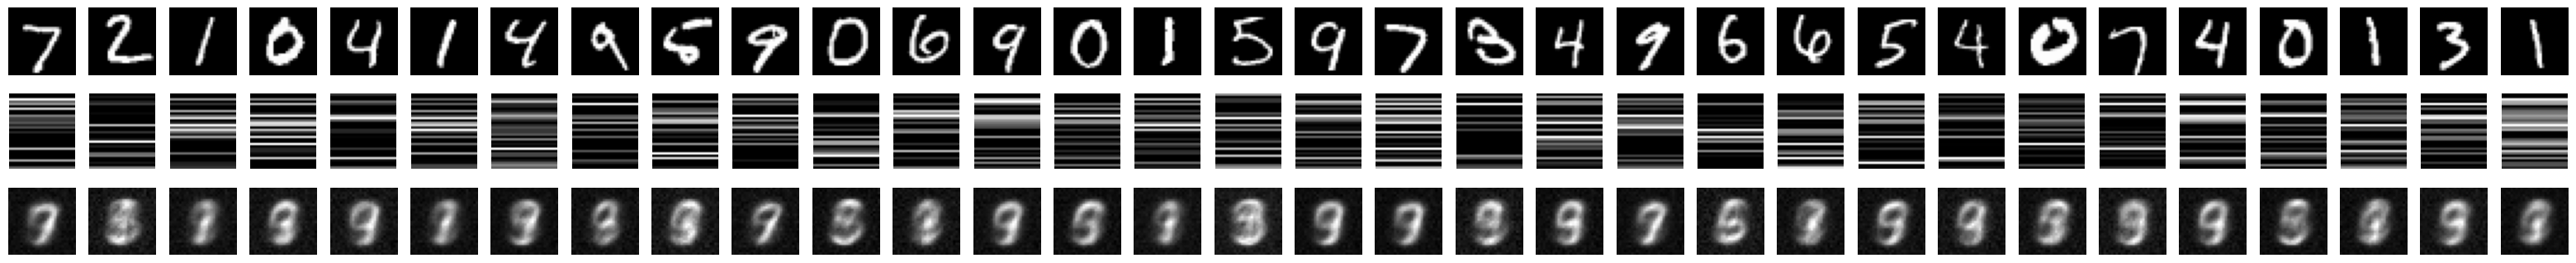

In [ ]:
import keras
from keras import layers
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from keras.utils import Sequence
from skimage.io import imread
import math
from sklearn.model_selection import train_test_split
from skimage.transform import resize
from scipy.stats import entropy
#tf.compat.v1.enable_eager_execution()

# https://www.tensorflow.org/datasets/catalog/
DATASET = 'mnist'
#DATASET = 'fashion_mnist'
#URL = "https://github.com/zalandoresearch/fashion-mnist/blob/master/data/fashion/train-images-idx3-ubyte.gz"

LATENT_SPACE_LENGTH = 32

img_width = 28
img_height = 28
img_length = img_height * img_width

# Generate the NumPy arrays with the data.
DATA_URL = f'https://storage.googleapis.com/tensorflow/tf-keras-datasets/{DATASET}.npz'
path = tf.keras.utils.get_file(f'{DATASET}.npz', DATA_URL)
with np.load(path) as data:
    x_train = data['x_train']
    y_train = data['x_train']
    x_test = data['x_test']
    y_test = data['x_test']

# Generate the pipelines.
train_DS = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_DS = tf.data.Dataset.from_tensor_slices((x_test, y_test))

# Define how to use the datasets, preprocess, etc.

def process_x(image, label):
    processed_img = tf.reshape(image, (img_height * img_width, 1))
    processed_img = tf.cast(processed_img, tf.float32) / 255.
    return processed_img, label

def process_y(image, label):
    # The last layer of the network is a dense layer and TensorFlow imposes 1D.
    return image, tf.reshape(image, (img_height * img_width, 1))

BATCH_SIZE = 1024
SHUFFLE_BUFFER_SIZE = 100
train_DS = train_DS.map(process_x)
train_DS = train_DS.map(process_y)
train_DS = train_DS.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_DS = test_DS.map(process_x)
test_DS = test_DS.map(process_y)
test_DS = test_DS.batch(BATCH_SIZE)

class Quantization_8bits(keras.layers.Layer):

    def __init__(self, units=32, **kwargs):
        super(Quantization_8bits, self).__init__(**kwargs)
        self.quantized_vals = 0

    def call(self, inputs):
        outputs = inputs
        outputs = tf.saturate_cast(tf.round(outputs * 255.), tf.int8)
        self.quantized_vals = outputs
        outputs = tf.cast(outputs, tf.float32) / 255.0
        return outputs

    def get_vals(self):
        return self.quantized_vals

# Define the autoencoder.
input_layer = keras.Input(
    shape=(img_length,),
    name="inputs")
hidden_layer = layers.Dense(
    LATENT_SPACE_LENGTH,
    activation="relu")(input_layer)
quantization_layer = Quantization_8bits(
    units=LATENT_SPACE_LENGTH,
    name="quantization"
    )(hidden_layer)
output_layer = layers.Dense(
    img_length,
    activation="sigmoid",
    name="outputs")(quantization_layer)

autoencoder = keras.Model(
    input_layer,
    output_layer)

# To see the latents (content of the hidden layer), we define a new "model" with only the encoder.
encoder = keras.Model(
    input_layer,
    hidden_layer)

autoencoder.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss="binary_crossentropy", run_eagerly=True
)

autoencoder.summary()

# Train.
EPOCHS = 1
ITERATIONS = 5
plt.gray()
for i in range(ITERATIONS):

    autoencoder.fit(
        train_DS,
        epochs=EPOCHS,
        validation_data=test_DS)

    batch_vals = autoencoder.get_layer("quantization").get_vals()
    print("batch_vals =", batch_vals)
    counter = 0
    for j in range(BATCH_SIZE):
        try:
            vals = batch_vals[j].numpy() + 512
            #print(vals)
            print(entropy(vals, base=2))
            if counter > 10:
              break
            counter += 1
        except:
            pass

    #print("2", autoencoder.get_layer("hidden").variables[1])

    # Show the learning.
    plt.figure(figsize=(40,4))

    n = len(train_DS)
    if n > 32:
        n = 32

    # Show the originals (using the pipeline).
    for images in test_DS.take(1):
        for i in range(n):
            ax = plt.subplot(3, n, i + 1)
            try:
                image = images[0][i].numpy()
                image *= 255
                image = image.astype("uint8").reshape(img_height, img_width)
                plt.imshow(image)
                #plt.gray()
                plt.axis("off")
            except:
                pass

    # See the latent space (as images).
    latent_imgs = encoder.predict(test_DS)
    print("type latent", type(latent_imgs))
    for i in range(n):
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(resize(latent_imgs[i],(LATENT_SPACE_LENGTH, img_width)))
        plt.axis("off")

    # See the reconstructions.
    reconstructed_imgs = autoencoder.predict(test_DS)
    print(type(reconstructed_imgs))
    for i in range(n):
        ax = plt.subplot(3, n, i + 1 + 2*n)
        plt.imshow(reconstructed_imgs[i].reshape(img_height, img_width))
        plt.axis("off")

    plt.show()

Quantization is not differentiable, and for this reason the autoencoder cannot be optimized.

##  3. Quantizing the latent space (only during inferencing)
During training, the quantization noise is simulated by adding uniform noise (but quantization is not performed). During the inference, the latents are truely quantized using 256 quantization levels.

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 784)]             0         
                                                                 
 dense_2 (Dense)             (None, 32)                25120     
                                                                 
 add_noise (AddNoise)        (None, 32)                0         
                                                                 
 outputs (Dense)             (None, 784)               25872     
                                                                 
Total params: 50992 (199.19 KB)
Trainable params: 50992 (199.19 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inp

<Figure size 640x480 with 0 Axes>

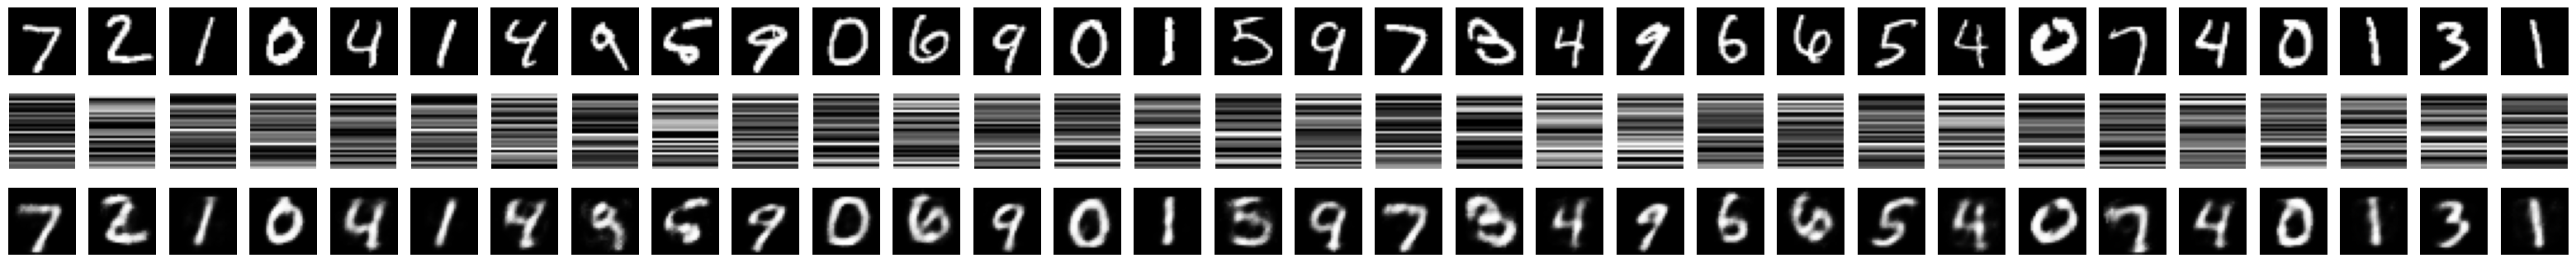

313/313 [==============================] - 1s 3ms/step
type latent <class 'numpy.ndarray'>
313/313 [==============================] - 2s 7ms/step
<class 'numpy.ndarray'>
batch_vals = tf.Tensor(
[[2551  491    0  823 1067 3391 2447 1288  315 1350 1553 1760  872  897
  1718 3316 1998 1194  707 2063 1441 2670  503 2764    0 2360 3085    0
   271 2328  227 1051]
 [4143 1654    0 2075 2419 2846 2544 2500 1131 1740 5275 1639 3955 4253
  2264    0 3766 1565 1830 4215 1732 3323 3200 2837    0 2675 1944  533
  2063 3090 1769 3240]
 [4081  788    0  609 3109 2263 1439 2607  867 2280 3363 3524 2330 3078
  3237  445 2839 3342 1530 3324 1770 4514 2252 4200    0 2579 1713  436
  2470 4005 2618 3111]
 [2376 2610    0 3574 1663 1557  993 1248 1605 1559 2470  457 1270 1134
  1423    0    0 2114  696 1764 1818 3896 2669 3552    0 2455 3251 2073
   587 3040 1407  413]
 [2741 1067    0 2215 2821 1154 1388 3158 3404 1452 2389  174 1097 1344
     0 2382 1837 3028    0 2497 1369 5559 4493 4591    0 1713 1319

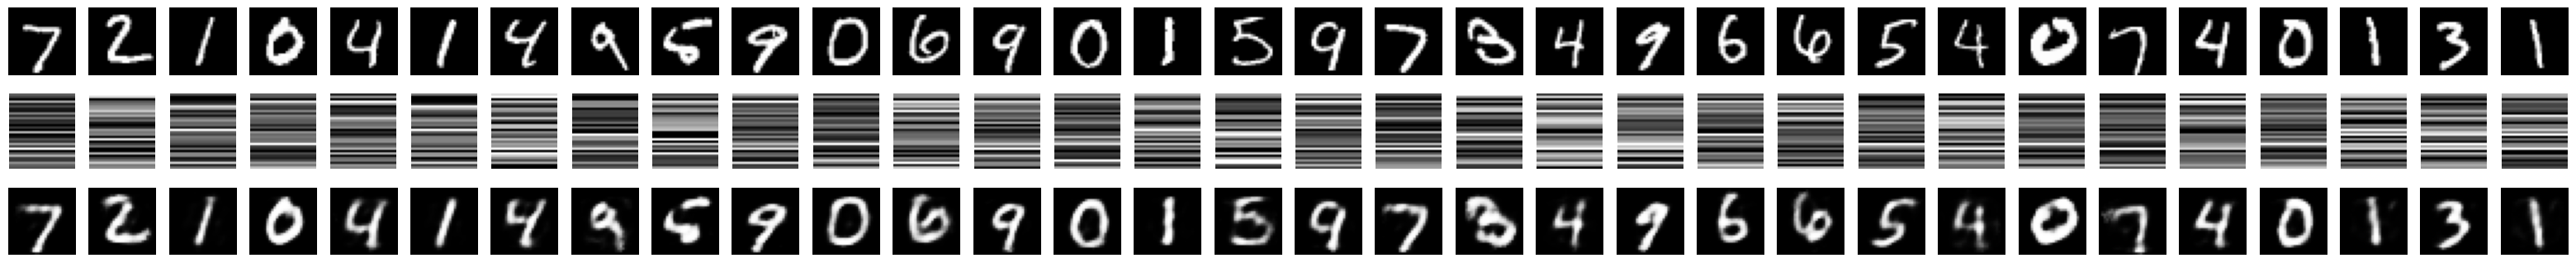

313/313 [==============================] - 1s 3ms/step
type latent <class 'numpy.ndarray'>
313/313 [==============================] - 2s 7ms/step
<class 'numpy.ndarray'>
batch_vals = tf.Tensor(
[[2678  765    0 1109 1308 3753 2615 1453  451 1582 1813 1964 1007 1076
  1863 3353 2166 1418  918 2252 1788 2961  633 3035    0 2625 3076   96
   530 2553  408 1179]
 [4484 1936    0 2325 2607 3333 2841 2751 1632 2225 5838 1936 4385 4544
  2290  447 4010 1859 1934 4473 1974 3573 3495 3230    0 3088 2007  915
  2383 3517 2136 3494]
 [4390 1091    0  832 3305 2645 1663 2857 1273 2623 3777 3941 2581 3349
  3337  815 3032 3684 1644 3458 2128 4924 2534 4605    0 2812 1836  694
  2761 4471 3018 3411]
 [2571 2850    0 3818 1893 1736 1081 1555 1830 1728 2645  610 1455 1388
  1572    0    0 2422  779 1723 2027 4177 2930 3791    0 2483 3444 2260
   778 3170 1563  505]
 [2917 1229    0 2478 3216 1444 1629 3460 3711 1612 2579  414 1360 1646
   414 2694 2183 3183    0 2664 1653 5929 4762 4933    0 1979 1512

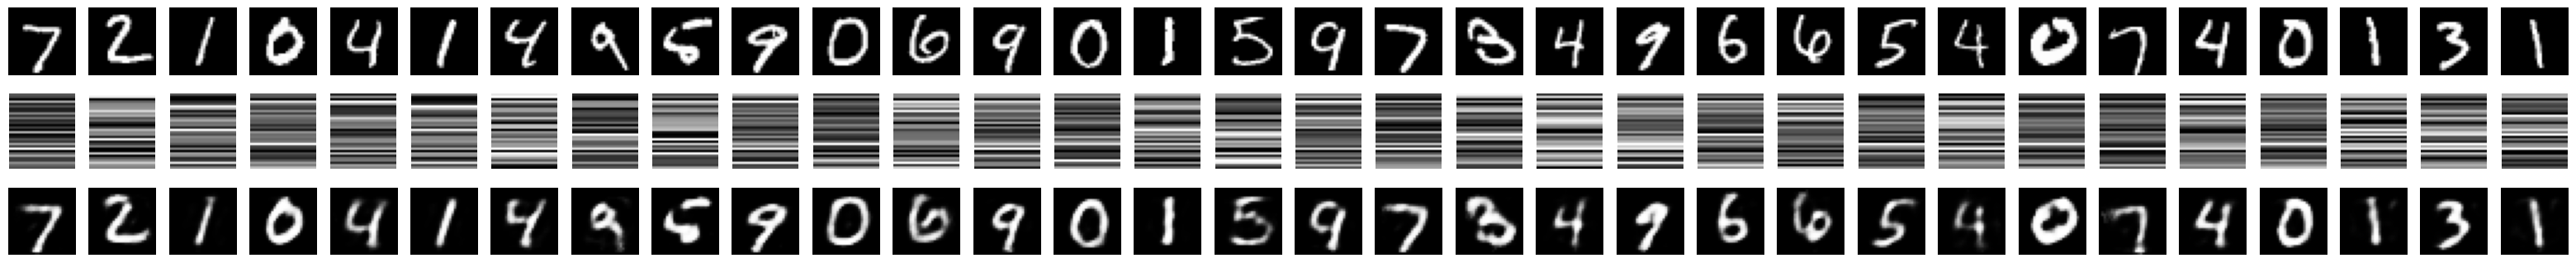

313/313 [==============================] - 1s 3ms/step
type latent <class 'numpy.ndarray'>
313/313 [==============================] - 2s 7ms/step
<class 'numpy.ndarray'>
batch_vals = tf.Tensor(
[[2612  891    0 1164 1450 3911 2666 1529  501 1691 1848 2096 1097 1129
  1946 3404 2278 1546 1053 2112 1978 2956  604 3101    0 2601 3157  231
   671 2534  511 1226]
 [4456 1963    0 2285 2669 3541 2968 2793 1782 2411 5900 2118 4605 4613
  2245  695 4104 2017 2041 4269 2085 3463 3404 3408    0 3143 2025 1131
  2635 3549 2336 3580]
 [4311 1207    0  775 3361 2796 1716 2877 1383 2804 3769 4197 2699 3436
  3370  985 3105 3835 1721 3219 2269 4923 2451 4730    0 2756 1917  826
  2892 4490 3212 3516]
 [2545 2952    0 3861 1987 1752 1067 1635 1905 1773 2624  696 1518 1461
  1639    0   59 2518  814 1494 2131 4143 2912 3903    0 2350 3557 2336
   882 3131 1605  576]
 [2825 1296    0 2518 3419 1577 1587 3549 3779 1708 2478  532 1492 1789
   650 2845 2331 3238    0 2500 1871 5961 4728 5070    0 2015 1607

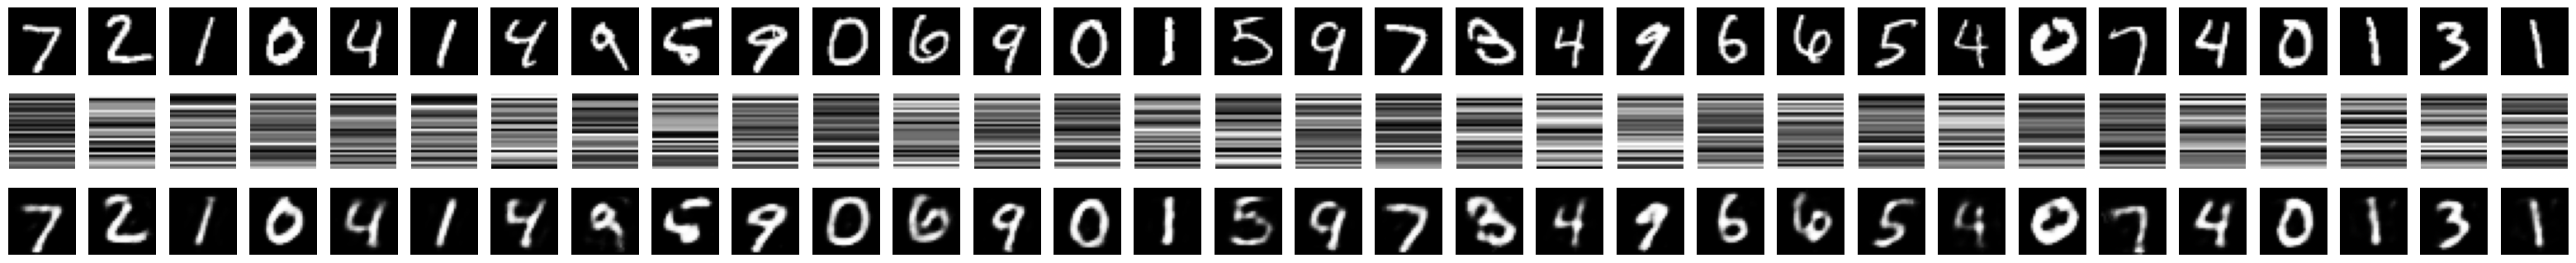

313/313 [==============================] - 1s 3ms/step
type latent <class 'numpy.ndarray'>
313/313 [==============================] - 2s 7ms/step
<class 'numpy.ndarray'>
batch_vals = tf.Tensor(
[[2591  945    0 1141 1505 3949 2706 1541  545 1766 1841 2139 1134 1129
  1982 3406 2318 1619 1118 1994 2043 2887  597 3141    0 2556 3227  300
   702 2500  557 1255]
 [4431 1903    0 2248 2716 3627 3026 2697 1895 2502 5820 2139 4680 4572
  2138  712 4116 2092 2098 4116 2097 3338 3352 3479    0 3169 2037 1236
  2716 3510 2422 3589]
 [4257 1263    0  669 3374 2833 1734 2762 1479 2937 3701 4291 2722 3419
  3334  998 3124 3900 1776 3069 2298 4792 2395 4778    0 2718 1968  890
  2877 4387 3310 3565]
 [2502 2939    0 3786 1974 1719 1053 1611 1968 1799 2561  767 1538 1478
  1631    0   93 2555  829 1333 2199 4034 2884 3944    0 2244 3641 2378
   912 3047 1653  648]
 [2795 1330    0 2426 3479 1619 1546 3519 3846 1811 2366  620 1526 1839
   730 2886 2353 3258    0 2360 1998 5868 4700 5161    0 2018 1664

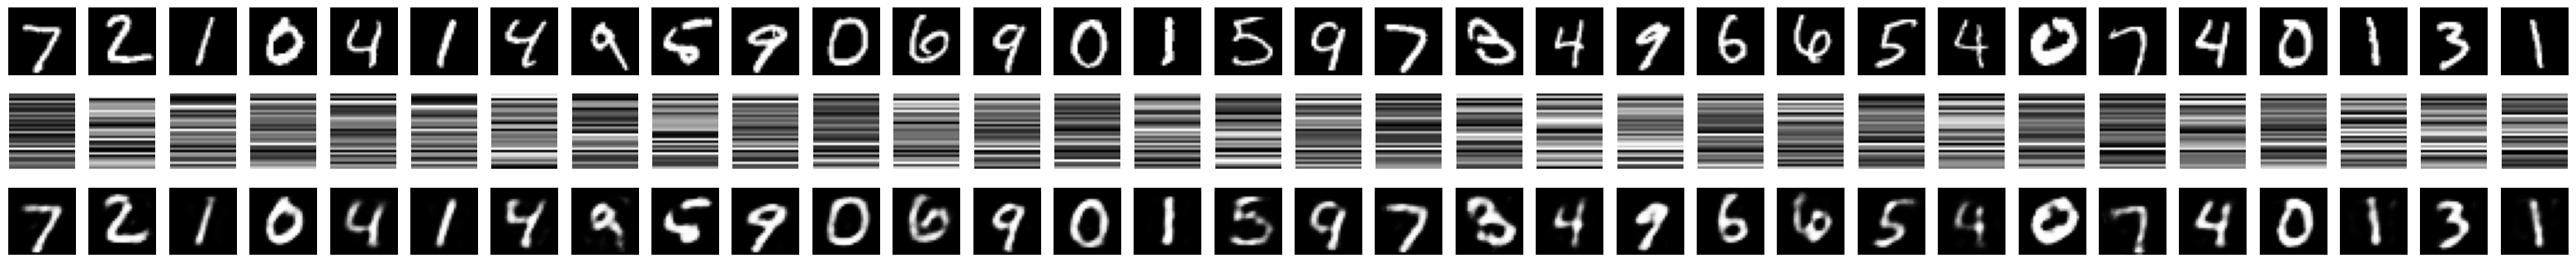

In [ ]:
import keras
from keras import layers
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from keras.utils import Sequence
from skimage.io import imread
import math
from sklearn.model_selection import train_test_split
from skimage.transform import resize
from scipy.stats import entropy
#tf.compat.v1.enable_eager_execution()

# https://www.tensorflow.org/datasets/catalog/
DATASET = 'mnist'
#DATASET = 'fashion_mnist'
#URL = "https://github.com/zalandoresearch/fashion-mnist/blob/master/data/fashion/train-images-idx3-ubyte.gz"

LATENT_SPACE_LENGTH = 32

img_width = 28
img_height = 28
img_length = img_height * img_width

# Generate the NumPy arrays with the data.
DATA_URL = f'https://storage.googleapis.com/tensorflow/tf-keras-datasets/{DATASET}.npz'
path = tf.keras.utils.get_file(f'{DATASET}.npz', DATA_URL)
with np.load(path) as data:
    x_train = data['x_train']
    y_train = data['x_train']
    x_test = data['x_test']
    y_test = data['x_test']

# Generate the pipelines.
train_DS = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_DS = tf.data.Dataset.from_tensor_slices((x_test, y_test))

# Define how to use the datasets, preprocess, etc.

def process_x(image, label):
    processed_img = tf.reshape(image, (img_height * img_width, 1))
    processed_img = tf.cast(processed_img, tf.float32) / 255.
    return processed_img, label

def process_y(image, label):
    # The last layer of the network is a dense layer and TensorFlow imposes 1D.
    return image, tf.reshape(image, (img_height * img_width, 1))

BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 100
train_DS = train_DS.map(process_x)
train_DS = train_DS.map(process_y)
train_DS = train_DS.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_DS = test_DS.map(process_x)
test_DS = test_DS.map(process_y)
test_DS = test_DS.batch(BATCH_SIZE)

class AddNoise(keras.layers.Layer):

    def __init__(self, units=32, **kwargs):
        super().__init__(**kwargs)

    def call(self, inputs):
        outputs = inputs
        outputs += tf.random.uniform(shape=tf.shape(inputs), minval=-.5, maxval=.5)
        return outputs

class Quantization_8bits(keras.layers.Layer):

    def __init__(self, units=32, **kwargs):
        super().__init__(**kwargs)
        self.quantized_vals = 0

    def call(self, inputs):
        outputs = inputs
        #print("a1", tf.reduce_min(outputs))
        #print("a2", tf.reduce_max(outputs))
        #outputs = tf.keras.activations.sigmoid(outputs - 0.5)#(outputs + 0.5)
        #print("d1", tf.reduce_min(outputs))
        #print("d2", tf.reduce_max(outputs))
        #output = outputs - 0.5
        outputs = tf.saturate_cast(tf.round(outputs * 255.), tf.int16)
        self.quantized_vals = outputs
        outputs = tf.cast(outputs, tf.float32) / 255.0
        return outputs

    def get_vals(self):
        return self.quantized_vals

# Define the autoencoder.
input_layer = keras.Input(
    shape=(img_length,),
    name="inputs")
hidden_layer = layers.Dense(
    LATENT_SPACE_LENGTH,
    activation="relu")(input_layer)
noisy_layer = AddNoise(
    units=LATENT_SPACE_LENGTH,
    name="add_noise"
    )(hidden_layer)
output_layer = layers.Dense(
    img_length,
    activation="sigmoid",
    name="outputs")(noisy_layer)

autoencoder = keras.Model(
    input_layer,
    output_layer)

# To see the latents (content of the hidden layer), we define a new "model" with only the encoder.
encoder = keras.Model(
    input_layer,
    hidden_layer)

autoencoder.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss="binary_crossentropy", run_eagerly=True
)

autoencoder.summary()

input_layer_2 = keras.Input(
    shape=(img_length,),
    name="inputs_2")
hidden_layer_2 = layers.Dense(
    LATENT_SPACE_LENGTH,
    activation="relu")(input_layer_2)
quantization_layer = Quantization_8bits(
    units=LATENT_SPACE_LENGTH,
    name="quantization"
    )(hidden_layer_2)
output_layer_2 = layers.Dense(
    img_length,
    activation="sigmoid",
    name="outputs_2")(quantization_layer)

autoencoder_2 = keras.Model(
    input_layer_2,
    output_layer_2
)

autoencoder_2.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss="binary_crossentropy", run_eagerly=True
)

autoencoder_2.summary()

# Train.
EPOCHS = 1
ITERATIONS = 5
plt.gray()
for i in range(ITERATIONS):

    autoencoder.fit(
        train_DS,
        epochs=EPOCHS,
        validation_data=test_DS)

    #print("2", autoencoder.get_layer("hidden").variables[1])

    # Show the learning.
    plt.figure(figsize=(40,4))

    n = len(train_DS)
    if n > 32:
        n = 32

    # Show the originals (using the pipeline).
    for images in test_DS.take(1):
        for i in range(n):
            ax = plt.subplot(3, n, i + 1)
            try:
                image = images[0][i].numpy()
                image *= 255
                image = image.astype("uint8").reshape(img_height, img_width)
                plt.imshow(image)
                #plt.gray()
                plt.axis("off")
            except:
                pass

    # See the latent space (as images).
    latent_imgs = encoder.predict(test_DS)
    print("type latent", type(latent_imgs))
    for i in range(n):
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(resize(latent_imgs[i],(LATENT_SPACE_LENGTH, img_width)))
        plt.axis("off")

    # See the reconstructions.
    autoencoder_2.set_weights(autoencoder.get_weights())
    reconstructed_imgs = autoencoder_2.predict(test_DS)
    print(type(reconstructed_imgs))
    for i in range(n):
        ax = plt.subplot(3, n, i + 1 + 2*n)
        plt.imshow(reconstructed_imgs[i].reshape(img_height, img_width))
        plt.axis("off")

    batch_vals = autoencoder_2.get_layer("quantization").get_vals()
    print("batch_vals =", batch_vals)
    for j in range(BATCH_SIZE):
        try:
            vals = batch_vals[j].numpy() + 512
            #print(vals)
            print(entropy(vals, base=2))
        except:
            pass

    plt.show()

##  4. Considering RD tradeoff
So far, the autoencoder has tried to minimize the distortion ($D%) without considering the number of bits that the encoding of the latent space requires. When we use an entropy encoder, where the length of the code-stream depends on the statistics of the symbols of the latent space, it is required to optimize also considering the length of the code-stream. Now $R$ should also be minimized.

Unfortunately, $D$ and $R$ cannot be minimized at the same time becase one of them are inversely related with the other (for example, if $R$ is minimized, $D$ grows). For this reason, we need to define a cost function that controls such trade-off between both optimization objectives. Such cost function is usually defined as the Lagrangian
\begin{equation}
  J = R + \lambda D,
\end{equation}
where the Lagrange multiplier $\lambda$ controls a point in the R-D curve.

Sumarizing, now we optimize the autoencoder by minimizing $J$. $R$ is estimated using the entropy of the latent space.

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.
rate:  tf.Tensor(1.8302125710533468, shape=(), dtype=float64)
distortion:  tf.Tensor(0.47133, shape=(), dtype=float32)
Epoch 1/5


Instructions for updating:
Use fn_output_signature instead


469/469 [==============================] - 14s 26ms/step - loss: 665.1360 - distortion_loss: 0.1322 - rate_loss: 3.9207 - distortion_pass_through_loss: 0.1322 - rate_pass_through_loss: 3.9210 - val_loss: 525.9345 - val_distortion_loss: 0.1043 - val_rate_loss: 4.3688 - val_distortion_pass_through_loss: 0.1043 - val_rate_pass_through_loss: 4.3693
Epoch 2/5
469/469 [==============================] - 9s 19ms/step - loss: 490.5453 - distortion_loss: 0.0972 - rate_loss: 4.4604 - distortion_pass_through_loss: 0.0972 - rate_pass_through_loss: 4.4605 - val_loss: 464.7522 - val_distortion_loss: 0.0920 - val_rate_loss: 4.5221 - val_distortion_pass_through_loss: 0.0921 - val_rate_pass_through_loss: 4.5221
Epoch 3/5
469/469 [==============================] - 10s 22ms/step - loss: 447.7841 - distortion_loss: 0.0886 - rate_loss: 4.5482 - distortion_pass_through_loss: 0.0886 - rate_pass_through_loss: 4.5482 - val_loss: 435.2564 - val_distortion_loss: 0.0861 - val_rate_loss: 4.5719 - val_distortion_pas

<Figure size 640x480 with 0 Axes>

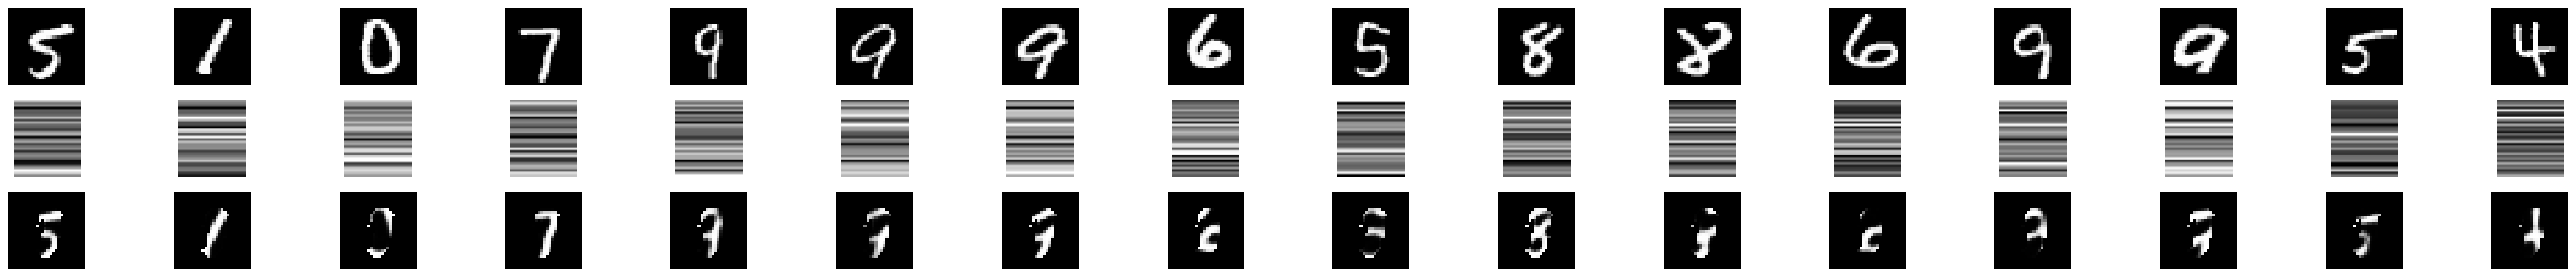

In [ ]:
import keras
from keras import layers
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from keras.utils import Sequence
from skimage.io import imread
import math
from sklearn.model_selection import train_test_split
from skimage.transform import resize
#from scipy.stats import entropy
#tf.compat.v1.enable_eager_execution()

# https://www.tensorflow.org/datasets/catalog/
DATASET = 'mnist'
#DATASET = 'fashion_mnist'
#URL = "https://github.com/zalandoresearch/fashion-mnist/blob/master/data/fashion/train-images-idx3-ubyte.gz"

LATENT_SPACE_LENGTH = 32

img_width = 28
img_height = 28
img_length = img_height * img_width

train_DS, test_DS = tfds.load(
    DATASET,
    split=["train", "test"],
    shuffle_files=True,
    as_supervised=True,
    with_info=False,
)

def encode(latent_dims):
  """Creates the analysis (encoder) transform."""
  return tf.keras.Sequential([
      tf.keras.layers.Input(
            shape=(img_length,), name="inputs"),
      tf.keras.layers.Dense(
          latent_dims, use_bias=True, activation="relu", name="latent"),
  ], name="analysis_transform")

def decode():
  """Creates the synthesis (decoder) transform."""
  return tf.keras.Sequential([
      tf.keras.layers.Dense(
          img_length, use_bias=True, activation="sigmoid", name="outputs"),
  ], name="synthesis_transform")


def estimate_rate(x):
    def entropy(row):
        _, _, count = tf.unique_with_counts(row)
        prob = count / tf.reduce_sum(count)
        _2 = tf.ones_like(prob)*2
        log_2 = tf.cast(tf.math.log(_2), tf.float64)
        #print(log_2.dtype, prob.dtype, tf.math.log(prob).dtype)
        #return -tf.reduce_sum(prob * tf.math.log(prob))
        return -tf.reduce_sum(prob * tf.math.log(prob)/log_2)

    #     rev = tf.map_fn(row_entropy, new_f_w_t,dtype=tf.float32)
    #entropy_batch = []
    #for j in range(len(batch)):
    #    entropy_batch.append(entropy(batch, base=2))
    #new_f_w_t = tf.histogram_fixed_width_bins(x, value_ranges, nbins)
    #rev = tf.map_fn(row_entropy, new_f_w_t,dtype=tf.float32)
    value_ranges = [0.0, 32.0]
    nbins = 256
    #print("estimate_rate.max(x)=",
    #      tf.reduce_max(x, axis = 1, keepdims = True),
    #      "estimate_rate.min(x)=",
    #      tf.reduce_min(x, axis = 1, keepdims = True))
    histograms = tf.cast(tf.histogram_fixed_width_bins(x, value_ranges, nbins), tf.float32)
    entropies = tf.map_fn(fn=entropy, elems=histograms, dtype=tf.float64)
    rate = tf.reduce_sum(entropies)
    #print("----------------___", histograms.dtype, entropies.dtype, rate.dtype)

    rate /= (tf.cast(tf.size(entropies), tf.float64))
    #tf.print("rate=", rate)
    return rate

class Trainer(tf.keras.Model):

    def __init__(self, latent_dims):
        super().__init__()
        self.encode = encode(latent_dims)
        self.decode = decode()

    def call(self, x):
        """Computes rate and distortion losses."""
        # Ensure inputs are floats in the range (0, 1).
        #tf.print("x=", x) # <- produces 0
        #print("max x", tf.reduce_max(x))

        x = tf.cast(x, self.compute_dtype) / 255.
        x = tf.reshape(x, (-1, 28*28))

        # Compute latent space representation y, perturb it and model its entropy,
        # then compute the reconstructed pixel-level representation x_hat.
        y = self.encode(x)
        #print("size(y)=", tf.size(y))
        #print("len(y)=", len(y))
        #print("shape(y)", tf.shape(y))
        #print("size(x)=", tf.size(x))
        #tf.print("x=", x)
        #tf.print("y=", y)

        rate = estimate_rate(y)
        x_hat = self.decode(y)
        #print("Autoencoder.call.max(y)=", tf.reduce_max(y))
        #print("Autoencoder.call.max(x)=", tf.reduce_max(x))
        #print("Autoencoder.call.max(x_hat)=", tf.reduce_max(x_hat))

        # Average number of bits per MNIST digit.
        rate = tf.reduce_mean(rate)

        # Mean absolute difference across pixels.
        distortion = tf.reduce_mean(abs(x - x_hat))

        return dict(rate=rate, distortion=distortion)

(example_batch, _), = test_DS.batch(32).take(1)
trainer = Trainer(10)
example_output = trainer(example_batch)

print("rate: ", example_output["rate"])
print("distortion: ", example_output["distortion"])

def pass_through_loss(_, x):
  # Since rate and distortion are unsupervised, the loss doesn't need a target.
  return x

def configure_training(lmbda, latent_dims=32):
    trainer = Trainer(latent_dims)
    trainer.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        # Just pass through rate and distortion as losses/metrics.
        loss=dict(rate=pass_through_loss, distortion=pass_through_loss),
        metrics=dict(rate=pass_through_loss, distortion=pass_through_loss),
        loss_weights=dict(rate=1., distortion=lmbda),)
    return trainer

def add_rd_targets(image, label):
    # Training is unsupervised, so labels aren't necessary here. However, we
    # need to add "dummy" targets for rate and distortion.
    #tf.print(image) <- produce 0
    #tf.print(label) <- produce labels
    processed_img = tf.reshape(image, (img_height * img_width, 1))
    #processed_img = tf.cast(processed_img, tf.float32) / 255.
    #tf.print(processed_img)
    return processed_img, dict(rate=0., distortion=0.)

def train(lmbda, epochs=5):
    trainer = configure_training(lmbda)
    #print("-----------")
    #tf.print(train_DS.take(16))
    #print("-----------")
    trainer.fit(
        train_DS.map(add_rd_targets).batch(128).prefetch(8),
        epochs=epochs,
        validation_data=test_DS.map(add_rd_targets).batch(128).cache(),
        #validation_data=train_DS.map(add_rd_targets).batch(128).cache(),
        validation_freq=1,
        verbose=1,
    )
    return trainer

trainer = train(lmbda=5000)
trainer.summary()

class Compressor(tf.keras.Model):
    def __init__(self, analysis_transform):
        super().__init__()
        self.analysis_transform = analysis_transform

    def call(self, x):
        # Ensure inputs are floats in the range (0, 1).
        x = tf.cast(x, self.compute_dtype) / 255.
        x = tf.reshape(x, (-1, 28*28))
        y = self.analysis_transform(x)
        #tf.print(y)
        #print("size(y)=", tf.size(y))
        # Also return the exact information content of each digit.
        rate = estimate_rate(y)
        rate = tf.reduce_mean(rate)
        return y, rate

class Decompressor(tf.keras.Model):
    def __init__(self, synthesis_transform):
        super().__init__()
        self.synthesis_transform = synthesis_transform

    def call(self, y):
        #tf.print(y)
        #print("Decompressor.call.max(y)", tf.reduce_max(y)) # Returns > 0
        x_hat = self.synthesis_transform(y)
        #print("Decompressor.call.max(x_hat)", tf.reduce_max(x_hat))
        # Scale and cast back to 8-bit integer.
        #tf.print(x_hat)
        #print("Decompressor.call.x_hat", tf.reduce_max(x_hat)) # Returns 0
        return tf.saturate_cast(tf.round(x_hat * 255.), tf.uint8)

def make_mnist_codec(trainer, **kwargs):
    # The entropy model must be created with `compression=True` and the same
    # instance must be shared between compressor and decompressor.
    compressor = Compressor(trainer.encode)
    decompressor = Decompressor(trainer.decode)
    return compressor, decompressor

compressor, decompressor = make_mnist_codec(trainer)

(originals, _), = test_DS.batch(16).skip(3).take(1)
y, entropies = compressor(originals)
print("shape(y)=", tf.shape(y), "max(y)=", tf.reduce_max(y), "entropies=", entropies)
reconstructed_imgs = decompressor(y)
print("shape(recons)=", tf.shape(reconstructed_imgs), "max(recons)=", tf.reduce_max(reconstructed_imgs))
n = len(reconstructed_imgs)
plt.gray()
plt.figure(figsize=(40,4))
for i in range(n):
    ax = plt.subplot(3, n, i + 1 )
    plt.imshow(tf.reshape(originals[i], (img_height, img_width)))
    plt.axis("off")
for i in range(n):
    ax = plt.subplot(3, n, i + 1 + n)
    #tf.print(reconstructed_imgs[i])
    plt.imshow(resize(y[i],(LATENT_SPACE_LENGTH, img_width)))
    #plt.imshow(tf.reshape(reconstructed_imgs[i], (img_height, img_width)))
    plt.axis("off")
for i in range(n):
    ax = plt.subplot(3, n, i + 1 + 2*n)
    #tf.print(reconstructed_imgs[i])
    plt.imshow(tf.reshape(reconstructed_imgs[i], (img_height, img_width)))
    plt.axis("off")
plt.show()

##  5. Adding some convolutional layers
Now, the dense ANN learns on shapes, not on pixels.

estimate_rate.max(x)= tf.Tensor(
[[0.12126047]
 [0.19227521]
 [0.09153694]
 [0.03179629]
 [0.0737468 ]
 [0.13733278]
 [0.11378455]
 [0.06277204]
 [0.18928654]
 [0.07634889]
 [0.08127543]
 [0.09366124]
 [0.11365341]
 [0.14210086]
 [0.09373613]
 [0.13816562]
 [0.17234913]
 [0.11739926]
 [0.0793857 ]
 [0.08413077]
 [0.10362995]
 [0.06417105]
 [0.14050676]
 [0.15298878]
 [0.07291046]
 [0.13904484]
 [0.04592123]
 [0.08259705]
 [0.0613023 ]
 [0.1077286 ]
 [0.0868566 ]
 [0.12036367]], shape=(32, 1), dtype=float32) estimate_rate.min(x)= tf.Tensor(
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]], shape=(32, 1), dtype=float32)
rate:  tf.Tensor(0.13190501069698535, shape=(), dtype=float64)
distortion:  tf.Tensor(0.14677787, shape=(), dtype=float32)
Epoch 1/5
estimate_rate.max(x)= Tensor("trainer_3/Max:0", shape=(None, 1), dtype=float32) estimate_rate.min

<Figure size 640x480 with 0 Axes>

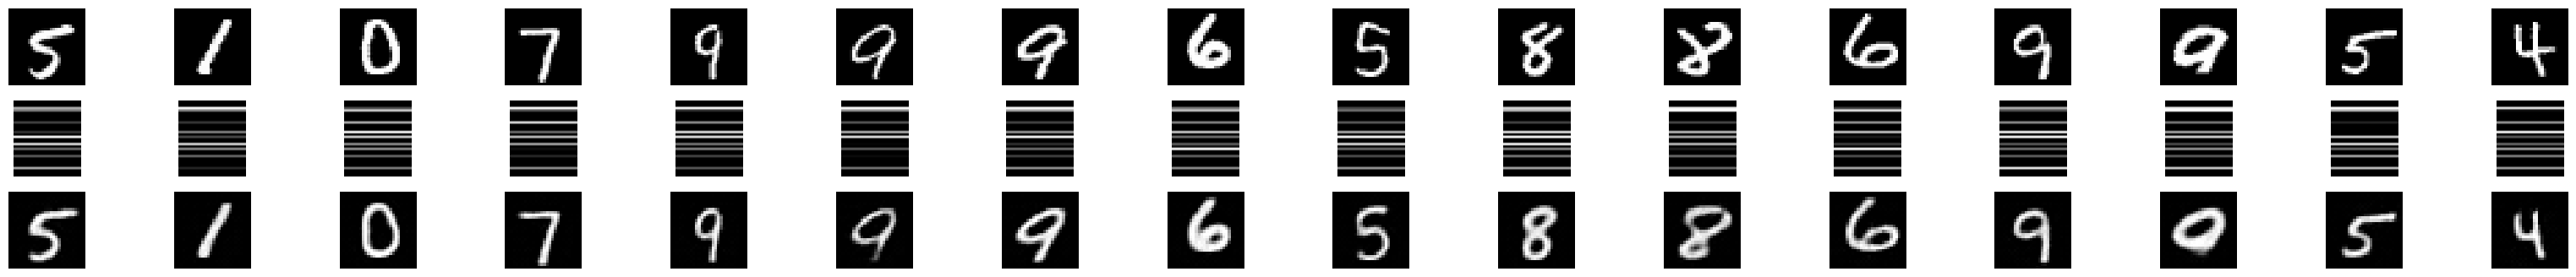

In [ ]:
import keras
from keras import layers
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from keras.utils import Sequence
from skimage.io import imread
import math
from sklearn.model_selection import train_test_split
from skimage.transform import resize
#from scipy.stats import entropy
#tf.compat.v1.enable_eager_execution()

# https://www.tensorflow.org/datasets/catalog/
DATASET = 'mnist'
#DATASET = 'fashion_mnist'
#URL = "https://github.com/zalandoresearch/fashion-mnist/blob/master/data/fashion/train-images-idx3-ubyte.gz"

LATENT_SPACE_LENGTH = 32

img_width = 28
img_height = 28
img_length = img_height * img_width

train_DS, test_DS = tfds.load(
    DATASET,
    split=["train", "test"],
    shuffle_files=True,
    as_supervised=True,
    with_info=False,
)

def encode(latent_dims):
  """Creates the analysis (encoder) transform."""
  return tf.keras.Sequential([
      tf.keras.layers.Conv2D(
          20, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2D(
          50, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_2"),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(
          500, use_bias=True, activation="leaky_relu", name="fc_1"),
      tf.keras.layers.Dense(
          latent_dims, use_bias=True, activation="relu", name="latent"),
  ], name="analysis_transform")

def decode():
  """Creates the synthesis (decoder) transform."""
  return tf.keras.Sequential([
      tf.keras.layers.Dense(
          500, use_bias=True, activation="leaky_relu", name="fc_1"),
      tf.keras.layers.Dense(
          2450, use_bias=True, activation="leaky_relu", name="fc_2"),
      tf.keras.layers.Reshape((7, 7, 50)),
      tf.keras.layers.Conv2DTranspose(
          20, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2DTranspose(
          1, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_2"),
  ], name="synthesis_transform")

def estimate_rate(x):
    def entropy(row):
        _, _, count = tf.unique_with_counts(row)
        prob = count / tf.reduce_sum(count)
        _2 = tf.ones_like(prob)*2
        log_2 = tf.cast(tf.math.log(_2), tf.float64)
        return -tf.reduce_sum(prob * tf.math.log(prob)/log_2)

    value_ranges = [0.0, 32.0]
    nbins = 256
    print("estimate_rate.max(x)=",
          tf.reduce_max(x, axis = 1, keepdims = True),
          "estimate_rate.min(x)=",
          tf.reduce_min(x, axis = 1, keepdims = True))
    histograms = tf.cast(tf.histogram_fixed_width_bins(x, value_ranges, nbins), tf.float32)
    entropies = tf.map_fn(fn=entropy, elems=histograms, dtype=tf.float64)
    rate = tf.reduce_sum(entropies)

    rate /= (tf.cast(tf.size(entropies), tf.float64))
    return rate

class Trainer(tf.keras.Model):

    def __init__(self, latent_dims):
        super().__init__()
        self.encode = encode(latent_dims)
        self.decode = decode()

    def call(self, x):
        """Computes rate and distortion losses."""
        # Ensure inputs are floats in the range (0, 1).
        x = tf.cast(x, self.compute_dtype) / 255.
        x = tf.reshape(x, (-1, 28, 28, 1))

        # Compute latent space representation y, perturb it and model its entropy,
        # then compute the reconstructed pixel-level representation x_hat.
        y = self.encode(x)

        rate = estimate_rate(y)
        x_hat = self.decode(y)

        # Average number of bits per MNIST digit.
        rate = tf.reduce_mean(rate)

        # Mean absolute difference across pixels.
        distortion = tf.reduce_mean(abs(x - x_hat))

        return dict(rate=rate, distortion=distortion)

(example_batch, _), = test_DS.batch(32).take(1)
trainer = Trainer(10)
example_output = trainer(example_batch)

print("rate: ", example_output["rate"])
print("distortion: ", example_output["distortion"])

def pass_through_loss(_, x):
  # Since rate and distortion are unsupervised, the loss doesn't need a target.
  return x

def configure_training(lmbda, latent_dims=32):
    trainer = Trainer(latent_dims)
    trainer.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        # Just pass through rate and distortion as losses/metrics.
        loss=dict(rate=pass_through_loss, distortion=pass_through_loss),
        metrics=dict(rate=pass_through_loss, distortion=pass_through_loss),
        loss_weights=dict(rate=1., distortion=lmbda),)
    return trainer

def add_rd_targets(image, label):
    # Training is unsupervised, so labels aren't necessary here. However, we
    # need to add "dummy" targets for rate and distortion.
    processed_img = tf.reshape(image, (img_height * img_width, 1))
    #processed_img = tf.cast(processed_img, tf.float32) / 255.
    return processed_img, dict(rate=0., distortion=0.)

def train(lmbda, epochs=5):
    trainer = configure_training(lmbda)
    trainer.fit(
        train_DS.map(add_rd_targets).batch(128).prefetch(8),
        epochs=epochs,
        validation_data=test_DS.map(add_rd_targets).batch(128).cache(),
        validation_freq=1,
        verbose=1,
    )
    return trainer

trainer = train(lmbda=500)
trainer.summary()

class Compressor(tf.keras.Model):
    def __init__(self, analysis_transform):
        super().__init__()
        self.analysis_transform = analysis_transform

    def call(self, x):
        # Ensure inputs are floats in the range (0, 1).
        x = tf.cast(x, self.compute_dtype) / 255.
        #x = tf.reshape(x, (-1, 28*28))
        y = self.analysis_transform(x)
        # Also return the exact information content of each digit.
        rate = estimate_rate(y)
        rate = tf.reduce_mean(rate)
        return y, rate

class Decompressor(tf.keras.Model):
    def __init__(self, synthesis_transform):
        super().__init__()
        self.synthesis_transform = synthesis_transform

    def call(self, y):
        x_hat = self.synthesis_transform(y)
        # Scale and cast back to 8-bit integer.
        return tf.saturate_cast(tf.round(x_hat * 255.), tf.uint8)

def make_mnist_codec(trainer, **kwargs):
    # The entropy model must be created with `compression=True` and the same
    # instance must be shared between compressor and decompressor.
    compressor = Compressor(trainer.encode)
    decompressor = Decompressor(trainer.decode)
    return compressor, decompressor

compressor, decompressor = make_mnist_codec(trainer)
(originals, _), = test_DS.batch(16).skip(3).take(1)
y, entropies = compressor(originals)
print("shape(y)=", tf.shape(y), "max(y)=", tf.reduce_max(y), "entropies=", entropies)
reconstructed_imgs = decompressor(y)
print("shape(recons)=", tf.shape(reconstructed_imgs), "max(recons)=", tf.reduce_max(reconstructed_imgs))
n = len(reconstructed_imgs)
plt.gray()
plt.figure(figsize=(40,4))
for i in range(n):
    ax = plt.subplot(3, n, i + 1 )
    plt.imshow(tf.reshape(originals[i], (img_height, img_width)))
    plt.axis("off")
for i in range(n):
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(resize(y[i],(LATENT_SPACE_LENGTH, img_width)))
    plt.axis("off")
for i in range(n):
    ax = plt.subplot(3, n, i + 1 + 2*n)
    #tf.print(reconstructed_imgs[i])
    plt.imshow(tf.reshape(reconstructed_imgs[i], (img_height, img_width)))
    plt.axis("off")
plt.show()

tf.Tensor([16 32], shape=(2,), dtype=int32)
tf.Tensor(
[[ 5.44110119e-01  2.07380310e-01  7.35643208e-02  4.64345515e-02
  -1.30158985e+00 -9.53856528e-01  8.41728568e-01  1.93968678e+00
   6.51257753e-01  1.10488665e+00  1.37462270e+00  1.14875197e+00
   1.08213139e+00  5.51049232e-01  7.00961426e-02  7.07385004e-01
   8.88570964e-01 -4.64327276e-01  1.20843327e+00 -7.90115952e-01
  -7.30490386e-01 -7.20753789e-01  3.65275264e-01 -1.69507593e-01
   2.03180790e-01 -9.02322948e-01 -6.50457859e-01  2.41527677e+00
   5.70346892e-01  8.77035379e-01  3.68764579e-01 -5.76170444e-01]
 [-6.61703765e-01 -1.02277565e+00  6.10901177e-01 -2.56390393e-01
   2.10671735e+00 -4.59748507e-02 -2.06909806e-01  6.32463574e-01
   4.22659993e-01  5.16539104e-02 -7.37364292e-01 -1.11440849e+00
   4.85859185e-01 -1.43682110e+00  1.78831708e+00  4.78447080e-01
  -1.37648273e+00  7.93998539e-01 -2.13322544e+00 -1.73031583e-01
  -1.74873459e+00 -4.69266385e-01 -1.55762172e+00 -8.94169569e-01
   2.19927981e-01  1

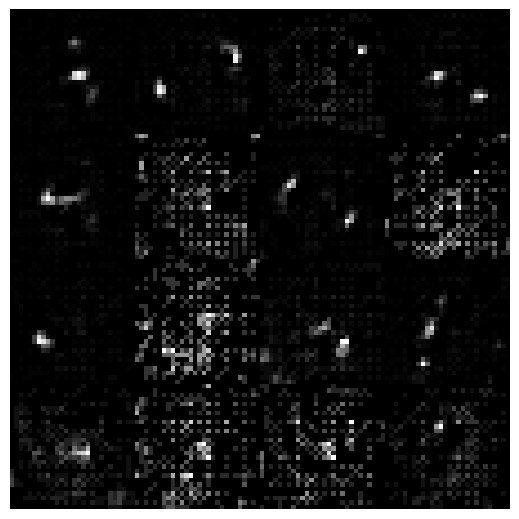

In [ ]:
import os

print(tf.shape(y))

#latent = tf.constant([os.urandom(8) for _ in range(16)])
#tf.print(latent)
latent = tf.random.stateless_normal(shape=[16, LATENT_SPACE_LENGTH], seed=[1, 2])
print(latent)
#input()
samples = decompressor(latent)

fig, axes = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(5, 5))
axes = axes.ravel()
for i in range(len(axes)):
  axes[i].imshow(tf.squeeze(samples[i]))
  axes[i].axis("off")
plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)


##  6. Variational Autoencoding
A VAE is an autoencoder that learns a latent variable model for its input data. So instead of letting the neural network learn an arbitrary function, it is learning the parameters of a probability distribution modeling the data. Now, if you sample points from this distribution, you can generate new input data samples: a VAE is a "generative model". See https://blog.keras.io/building-autoencoders-in-keras.html.

In [ ]:
# Based on https://keras.io/examples/generative/vae/ and
# https://www.tensorflow.org/tutorials/generative/data_compression

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

EPOCHS = 1
#EPOCHS = 30
LAMBDA = 1.0

def estimate_rate(x):
    def entropy(row):
        _, _, count = tf.unique_with_counts(row)
        prob = count / tf.reduce_sum(count)
        _2 = tf.ones_like(prob)*2
        log_2 = tf.cast(tf.math.log(_2), tf.float64)
        return -tf.reduce_sum(prob * tf.math.log(prob)/log_2)

    value_ranges = [0.0, 32.0]
    nbins = 256
    print("estimate_rate.max(x)=",
          tf.reduce_max(x, axis = 1, keepdims = True),
          "estimate_rate.min(x)=",
          tf.reduce_min(x, axis = 1, keepdims = True))
    histograms = tf.cast(tf.histogram_fixed_width_bins(x, value_ranges, nbins), tf.float32)
    entropies = tf.map_fn(fn=entropy, elems=histograms, dtype=tf.float64)
    rate = tf.reduce_sum(entropies)

    rate /= (tf.cast(tf.size(entropies), tf.float64))
    return tf.cast(rate, tf.float32)

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            z_mean_entropy = estimate_rate(z_mean)
            z_log_var_entropy = estimate_rate(z_log_var)
            total_entropy = (z_mean_entropy + z_log_var_entropy)/2.0  # Both have the same length
            tf.print("\ntotal_entropy=", total_entropy)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = total_entropy + LAMBDA*(reconstruction_loss + kl_loss)
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x = np.concatenate([x_train, x_test], axis=0)
x = np.expand_dims(x, -1).astype("float32") / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(x=x, epochs=EPOCHS, batch_size=128)

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 14, 14, 32)           320       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 7, 7, 64)             18496     ['conv2d[0][0]']              
                                                                                                  
 flatten_2 (Flatten)         (None, 3136)                 0         ['conv2d_1[0][0]']            
                                                                                            

1/1 [==============================] - 0s 23ms/step


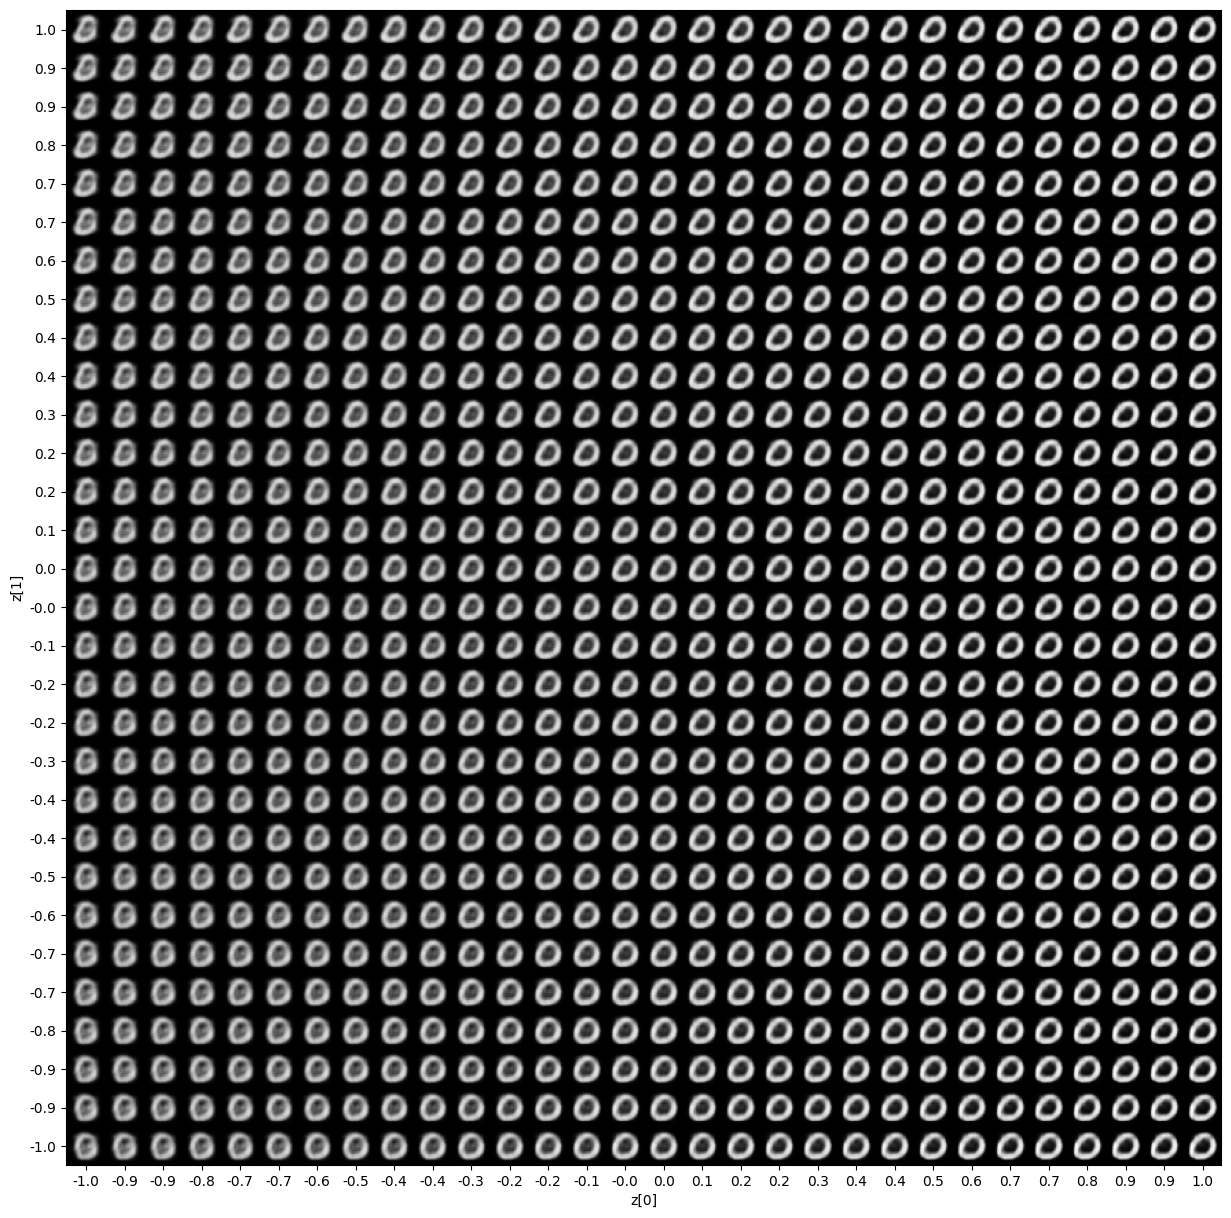

In [ ]:
import matplotlib.pyplot as plt

def plot_latent_space(vae, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(vae)


In [ ]:
z_mean, z_log_var, z = encoder.predict(x[0:16])
y = decoder.predict(z)

1/1 [==============================] - 0s 45ms/step


<Figure size 640x480 with 0 Axes>

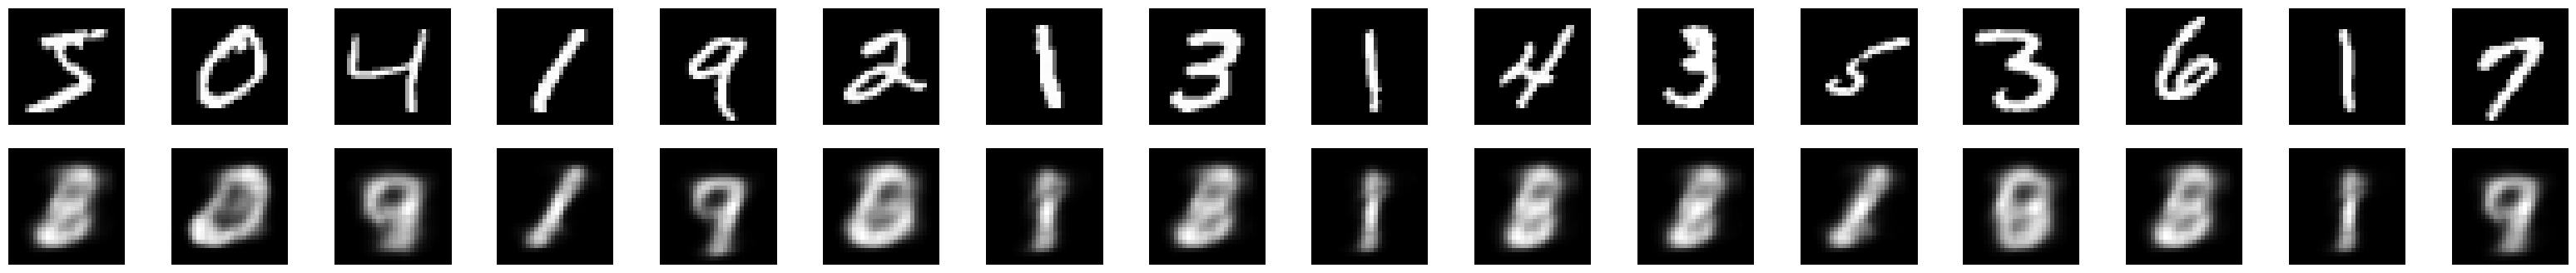

In [ ]:
n = len(y)
plt.gray()
plt.figure(figsize=(40,4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1 )
    plt.imshow(tf.reshape(x[i], (img_height, img_width)))
    plt.axis("off")
for i in range(n):
    ax = plt.subplot(2, n, i + 1 + n)
    #tf.print(reconstructed_imgs[i])
    plt.imshow(tf.reshape(y[i], (img_height, img_width)))
    plt.axis("off")
plt.show()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 14, 14, 32)           320       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 7, 7, 64)             18496     ['conv2d[0][0]']              
                                                                                                  
 flatten (Flatten)           (None, 3136)                 0         ['conv2d_1[0][0]']            
                                                                                            

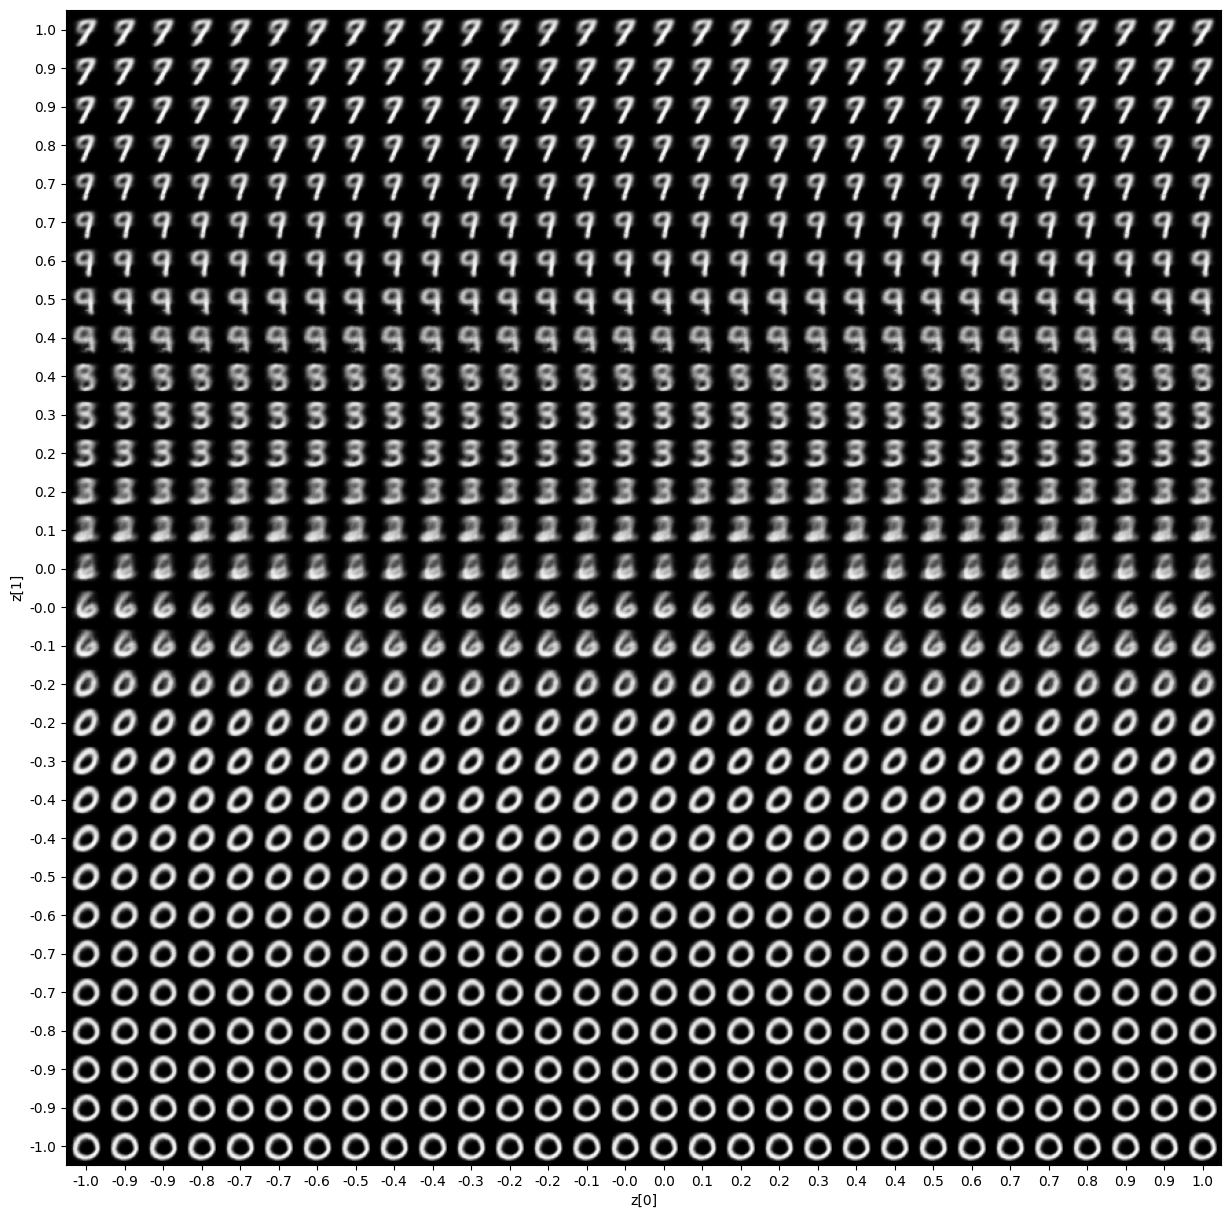

In [ ]:
# https://keras.io/examples/generative/vae/

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

#EPOCHS = 5
EPOCHS = 20

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(mnist_digits, epochs=EPOCHS, batch_size=128)

import matplotlib.pyplot as plt

def plot_latent_space(vae, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(vae)


In [ ]:
z_mean, z_log_var, z = encoder.predict(x[0:16])
y = decoder.predict(z)
print("sampling (one for each encoded image):")
print(tf.shape(z))
tf.print(z)
print("means:")
print(tf.shape(z_mean))
tf.print(z_mean)
print("log variances:")
print(tf.shape(z_log_var))
tf.print(z_log_var)
n = len(y)
plt.gray()
plt.figure(figsize=(40,4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1 )
    plt.imshow(tf.reshape(x[i], (img_height, img_width)))
    plt.axis("off")
for i in range(n):
    ax = plt.subplot(2, n, i + 1 + n)
    #tf.print(reconstructed_imgs[i])
    plt.imshow(tf.reshape(y[i], (img_height, img_width)))
    plt.axis("off")
plt.show()

TypeError: ignored

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.
estimate_rate.max(x)= tf.Tensor(
[[0.11496494]
 [0.17050481]
 [0.1391384 ]
 [0.06377632]
 [0.13897702]
 [0.12260421]
 [0.19845898]
 [0.08344051]
 [0.13090433]
 [0.08065937]
 [0.11805144]
 [0.22687122]
 [0.08976179]
 [0.08211483]
 [0.10073219]
 [0.15336171]
 [0.13451475]
 [0.1381234 ]
 [0.09355614]
 [0.17389928]
 [0.07869896]
 [0.07550429]
 [0.1090425 ]
 [0.14850593]
 [0.12198829]
 [0.1418529 ]
 [0.06332226]
 [0.14681184]
 [0.08639282]
 [0.06536258]
 [0.19157758]
 [0.10220147]], shape=(32, 1), dtype=float32) estimate_rate.min(x)= tf.Tensor(
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]], shape=(32, 1), dtype=float32)
rate:  tf.Tensor(0.23680213485757068, shape=(), dtype=float64)
distortion:  tf.Tensor(0.14686167, shape=(), dty

Instructions for updating:
Use fn_output_signature instead


estimate_rate.max(x)= Tensor("trainer_1/Max:0", shape=(None, 1), dtype=float32) estimate_rate.min(x)= Tensor("trainer_1/Min:0", shape=(None, 1), dtype=float32)
estimate_rate.max(x)= Tensor("trainer_1/Max:0", shape=(None, 1), dtype=float32) estimate_rate.min(x)= Tensor("trainer_1/Min:0", shape=(None, 1), dtype=float32)
469/469 [==============================] - 54s 109ms/step - loss: 626.6483 - distortion_loss: 0.1253 - rate_loss: 3.3171e-04 - distortion_pass_through_loss: 0.1253 - rate_pass_through_loss: 3.3153e-04 - val_loss: 628.5710 - val_distortion_loss: 0.1257 - val_rate_loss: 0.0000e+00 - val_distortion_pass_through_loss: 0.1257 - val_rate_pass_through_loss: 0.0000e+00
Epoch 2/5
469/469 [==============================] - 44s 93ms/step - loss: 294.1802 - distortion_loss: 0.0584 - rate_loss: 1.9412 - distortion_pass_through_loss: 0.0584 - rate_pass_through_loss: 1.9415 - val_loss: 192.6854 - val_distortion_loss: 0.0380 - val_rate_loss: 2.5299 - val_distortion_pass_through_loss: 0.0

<Figure size 640x480 with 0 Axes>

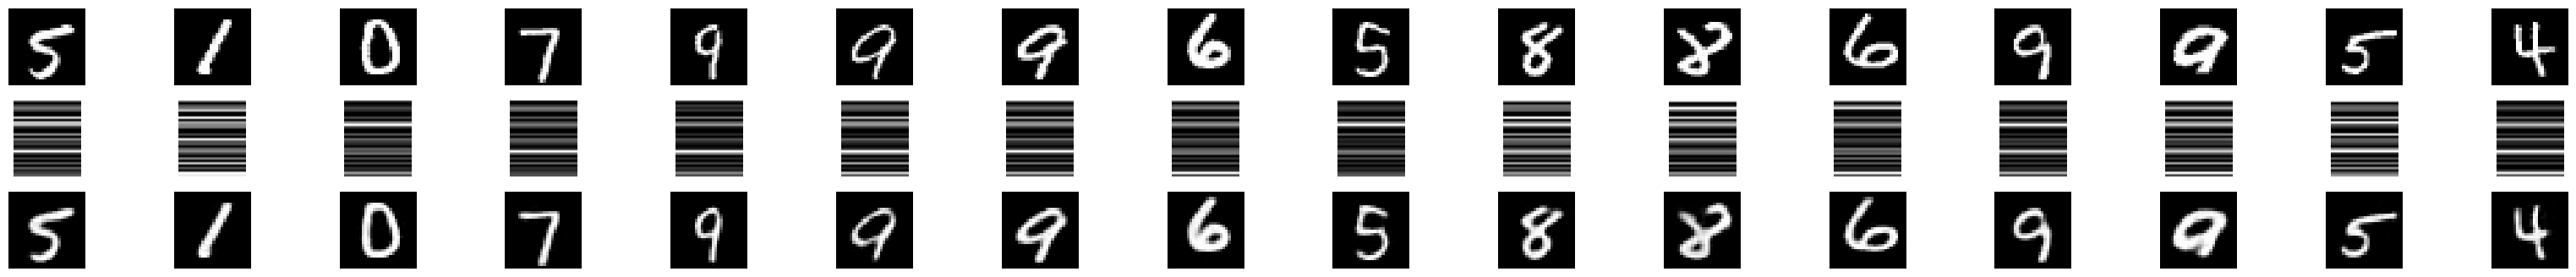

In [ ]:
import keras
from keras import layers
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from keras.utils import Sequence
from skimage.io import imread
import math
from sklearn.model_selection import train_test_split
from skimage.transform import resize
#from scipy.stats import entropy
#tf.compat.v1.enable_eager_execution()

# https://www.tensorflow.org/datasets/catalog/
DATASET = 'mnist'
#DATASET = 'fashion_mnist'
#URL = "https://github.com/zalandoresearch/fashion-mnist/blob/master/data/fashion/train-images-idx3-ubyte.gz"

LATENT_SPACE_LENGTH = 32

img_width = 28
img_height = 28
img_length = img_height * img_width

train_DS, test_DS = tfds.load(
    DATASET,
    split=["train", "test"],
    shuffle_files=True,
    as_supervised=True,
    with_info=False,
)

def encode(latent_dims):
  """Creates the analysis (encoder) transform."""
  return tf.keras.Sequential([
      tf.keras.layers.Conv2D(
          20, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2D(
          50, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_2"),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(
          500, use_bias=True, activation="leaky_relu", name="fc_1"),
      tf.keras.layers.Dense(
          latent_dims, use_bias=True, activation="relu", name="latent"),
  ], name="analysis_transform")

def decode():
  """Creates the synthesis (decoder) transform."""
  return tf.keras.Sequential([
      tf.keras.layers.Dense(
          500, use_bias=True, activation="leaky_relu", name="fc_1"),
      tf.keras.layers.Dense(
          2450, use_bias=True, activation="leaky_relu", name="fc_2"),
      tf.keras.layers.Reshape((7, 7, 50)),
      tf.keras.layers.Conv2DTranspose(
          20, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2DTranspose(
          1, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_2"),
  ], name="synthesis_transform")

def estimate_rate(x):
    def entropy(row):
        _, _, count = tf.unique_with_counts(row)
        prob = count / tf.reduce_sum(count)
        _2 = tf.ones_like(prob)*2
        log_2 = tf.cast(tf.math.log(_2), tf.float64)
        return -tf.reduce_sum(prob * tf.math.log(prob)/log_2)

    value_ranges = [0.0, 32.0]
    nbins = 256
    print("estimate_rate.max(x)=",
          tf.reduce_max(x, axis = 1, keepdims = True),
          "estimate_rate.min(x)=",
          tf.reduce_min(x, axis = 1, keepdims = True))
    histograms = tf.cast(tf.histogram_fixed_width_bins(x, value_ranges, nbins), tf.float32)
    entropies = tf.map_fn(fn=entropy, elems=histograms, dtype=tf.float64)
    rate = tf.reduce_sum(entropies)

    rate /= (tf.cast(tf.size(entropies), tf.float64))
    return rate

class Trainer(tf.keras.Model):

    def __init__(self, latent_dims):
        super().__init__()
        self.encode = encode(latent_dims)
        self.decode = decode()

    def call(self, x):
        """Computes rate and distortion losses."""
        # Ensure inputs are floats in the range (0, 1).
        x = tf.cast(x, self.compute_dtype) / 255.
        x = tf.reshape(x, (-1, 28, 28, 1))

        # Compute latent space representation y, perturb it and model its entropy,
        # then compute the reconstructed pixel-level representation x_hat.
        y = self.encode(x)

        rate = estimate_rate(y)
        x_hat = self.decode(y)

        # Average number of bits per MNIST digit.
        rate = tf.reduce_mean(rate)

        # Mean absolute difference across pixels.
        distortion = tf.reduce_mean(abs(x - x_hat))

        return dict(rate=rate, distortion=distortion)

(example_batch, _), = test_DS.batch(32).take(1)
trainer = Trainer(10)
example_output = trainer(example_batch)

print("rate: ", example_output["rate"])
print("distortion: ", example_output["distortion"])

def pass_through_loss(_, x):
  # Since rate and distortion are unsupervised, the loss doesn't need a target.
  return x

def configure_training(lmbda, latent_dims=50):
    trainer = Trainer(latent_dims)
    trainer.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        # Just pass through rate and distortion as losses/metrics.
        loss=dict(rate=pass_through_loss, distortion=pass_through_loss),
        metrics=dict(rate=pass_through_loss, distortion=pass_through_loss),
        loss_weights=dict(rate=1., distortion=lmbda),)
    return trainer

def add_rd_targets(image, label):
    # Training is unsupervised, so labels aren't necessary here. However, we
    # need to add "dummy" targets for rate and distortion.
    processed_img = tf.reshape(image, (img_height * img_width, 1))
    #processed_img = tf.cast(processed_img, tf.float32) / 255.
    return processed_img, dict(rate=0., distortion=0.)

def train(lmbda, epochs=5):
    trainer = configure_training(lmbda)
    trainer.fit(
        train_DS.map(add_rd_targets).batch(128).prefetch(8),
        epochs=epochs,
        validation_data=test_DS.map(add_rd_targets).batch(128).cache(),
        validation_freq=1,
        verbose=1,
    )
    return trainer

trainer = train(lmbda=5000)

class Compressor(tf.keras.Model):
    def __init__(self, analysis_transform):
        super().__init__()
        self.analysis_transform = analysis_transform

    def call(self, x):
        # Ensure inputs are floats in the range (0, 1).
        x = tf.cast(x, self.compute_dtype) / 255.
        #x = tf.reshape(x, (-1, 28*28))
        y = self.analysis_transform(x)
        # Also return the exact information content of each digit.
        rate = estimate_rate(y)
        rate = tf.reduce_mean(rate)
        return y, rate

class Decompressor(tf.keras.Model):
    def __init__(self, synthesis_transform):
        super().__init__()
        self.synthesis_transform = synthesis_transform

    def call(self, y):
        x_hat = self.synthesis_transform(y)
        # Scale and cast back to 8-bit integer.
        return tf.saturate_cast(tf.round(x_hat * 255.), tf.uint8)

def make_mnist_codec(trainer, **kwargs):
    # The entropy model must be created with `compression=True` and the same
    # instance must be shared between compressor and decompressor.
    compressor = Compressor(trainer.encode)
    decompressor = Decompressor(trainer.decode)
    return compressor, decompressor

compressor, decompressor = make_mnist_codec(trainer)
(originals, _), = test_DS.batch(16).skip(3).take(1)
y, entropies = compressor(originals)
print("shape(y)=", tf.shape(y), "max(y)=", tf.reduce_max(y), "entropies=", entropies)
reconstructed_imgs = decompressor(y)
print("shape(recons)=", tf.shape(reconstructed_imgs), "max(recons)=", tf.reduce_max(reconstructed_imgs))
n = len(reconstructed_imgs)
plt.gray()
plt.figure(figsize=(40,4))
for i in range(n):
    ax = plt.subplot(3, n, i + 1 )
    plt.imshow(tf.reshape(originals[i], (img_height, img_width)))
    plt.axis("off")
for i in range(n):
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(resize(y[i],(LATENT_SPACE_LENGTH, img_width)))
    plt.axis("off")
for i in range(n):
    ax = plt.subplot(3, n, i + 1 + 2*n)
    #tf.print(reconstructed_imgs[i])
    plt.imshow(tf.reshape(reconstructed_imgs[i], (img_height, img_width)))
    plt.axis("off")
plt.show()

In [ ]:
import keras
from keras import layers
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from keras.utils import Sequence
from skimage.io import imread
import math
from sklearn.model_selection import train_test_split
from skimage.transform import resize
from scipy.stats import entropy
#tf.compat.v1.enable_eager_execution()

# https://www.tensorflow.org/datasets/catalog/
DATASET = 'mnist'
#DATASET = 'fashion_mnist'
#URL = "https://github.com/zalandoresearch/fashion-mnist/blob/master/data/fashion/train-images-idx3-ubyte.gz"

LATENT_SPACE_LENGTH = 32

img_width = 28
img_height = 28
img_length = img_height * img_width

# Generate the NumPy arrays with the data.
DATA_URL = f'https://storage.googleapis.com/tensorflow/tf-keras-datasets/{DATASET}.npz'
path = tf.keras.utils.get_file(f'{DATASET}.npz', DATA_URL)
with np.load(path) as data:
    x_train = data['x_train']
    y_train = data['x_train']
    x_test = data['x_test']
    y_test = data['x_test']

# Generate the pipelines.
train_DS = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_DS = tf.data.Dataset.from_tensor_slices((x_test, y_test))

# Define how to use the datasets, preprocess, etc.

def process_x(image, label):
    processed_img = tf.reshape(image, (img_height * img_width, 1))
    processed_img = tf.cast(processed_img, tf.float32) / 255.
    return processed_img, label

def process_y(image, label):
    # The last layer of the network is a dense layer and TensorFlow imposes 1D.
    return image, tf.reshape(image, (img_height * img_width, 1))

BATCH_SIZE = 1024
SHUFFLE_BUFFER_SIZE = 100
train_DS = train_DS.map(process_x)
train_DS = train_DS.map(process_y)
train_DS = train_DS.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_DS = test_DS.map(process_x)
test_DS = test_DS.map(process_y)
test_DS = test_DS.batch(BATCH_SIZE)

class NoisyDense(keras.layers.Layer):

    def __init__(self, units=32, input_dim=32, activation="relu", **kwargs):
        super(NoisyDense, self).__init__(**kwargs)
        w_init = tf.random_normal_initializer()
        self.w = tf.Variable(
            initial_value=w_init(shape=(input_dim, units), dtype="float32"),
            trainable=True,
        )
        b_init = tf.zeros_initializer()
        self.b = tf.Variable(
            initial_value=b_init(shape=(units,), dtype="float32"), trainable=True
        )
        self.quantized_vals = 0

    #@tf.function
    def call(self, inputs):
        outputs = tf.matmul(inputs, self.w) + self.b
        #noise = tf.random.uniform(shape=tf.shape(weighted_sums), minval=-.5, maxval=.5)
        #quantized_sums_01 = weighted_sums
        #quantized_sums_01 = noise + weighted_sums
        #print(tf.reduce_max(weighted_sums))
        #outputs = tf.keras.activations.tanh(outputs)
        outputs = tf.saturate_cast(tf.round(outputs * 255.), tf.int16)
        #quantized_sums_8b = tf.saturate_cast(tf.round(weighted_sums * 255.), tf.int16)
        self.quantized_vals = outputs
        #print(len(self.quantized_vals))
        outputs = tf.cast(outputs, tf.float32) / 255.0
        #activations = tf.keras.activations.relu(quantized_sums_01)
        #activations = quantized_sums_01
        #print(len(activations))
        #tf.print(activations)
        #print(type(activations))
        #print("act[0][0] =",activations[0][0])
        #print(activations.numpy())
        #activations_entropy = entropy(tf.make_ndarray(activations), base=2)
        #self.codestream_length = activations_entropy * tf.size(activations)
        return outputs

    def get_vals(self):
        return self.quantized_vals

# Define the autoencoder.
input_layer = keras.Input(
    shape=(img_length,),
    name="inputs")
hidden_layer = NoisyDense(
    units=LATENT_SPACE_LENGTH,
    input_dim = img_length,
    activation="relu",
    name="hidden"
    )(input_layer)
output_layer = layers.Dense(
    img_length,
    activation="sigmoid",
    name="outputs")(hidden_layer)

autoencoder = keras.Model(
    input_layer,
    output_layer)

# To see the latents (content of the hidden layer), we define a new "model" with only the encoder.
encoder = keras.Model(
    input_layer,
    hidden_layer)

autoencoder.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss="binary_crossentropy", run_eagerly=True
)

autoencoder.summary()

# Train.
EPOCHS = 1
ITERATIONS = 1
plt.gray()
for i in range(ITERATIONS):

    autoencoder.fit(
        train_DS,
        epochs=EPOCHS,
        validation_data=test_DS)

    batch_vals = autoencoder.get_layer("hidden").get_vals()
    print("batch_vals =", batch_vals)
    for j in range(BATCH_SIZE):
        vals = batch_vals[j].numpy() + 512
        #print(vals)
        print(entropy(vals, base=2))

    #print("2", autoencoder.get_layer("hidden").variables[1])

    # Show the learning.
    plt.figure(figsize=(40,4))

    n = len(train_DS)
    if n > 32:
        n = 32

    # Show the originals (using the pipeline).
    for images in test_DS.take(1):
        for i in range(n):
            ax = plt.subplot(3, n, i + 1)
            try:
                image = images[0][i].numpy()
                image *= 255
                image = image.astype("uint8").reshape(img_height, img_width)
                plt.imshow(image)
                #plt.gray()
                plt.axis("off")
            except:
                pass

    # See the latent space (as images).
    latent_imgs = encoder.predict(test_DS)
    print("type latent", type(latent_imgs))
    for i in range(n):
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(resize(latent_imgs[i],(LATENT_SPACE_LENGTH, img_width)))
        plt.axis("off")

    # See the reconstructions.
    reconstructed_imgs = autoencoder.predict(test_DS)
    print(type(reconstructed_imgs))
    for i in range(n):
        ax = plt.subplot(3, n, i + 1 + 2*n)
        plt.imshow(reconstructed_imgs[i].reshape(img_height, img_width))
        plt.axis("off")

    plt.show()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 784)]             0         
                                                                 
 hidden (NoisyDense)         (None, 32)                25120     
                                                                 
 outputs (Dense)             (None, 784)               25872     
                                                                 
Total params: 50992 (199.19 KB)
Trainable params: 50992 (199.19 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


 1/59 [..............................] - ETA: 24s - loss: 0.6951

 3/59 [>.............................] - ETA: 2s - loss: 0.6918 

 4/59 [=>............................] - ETA: 2s - loss: 0.6902

 5/59 [=>............................] - ETA: 2s - loss: 0.6887

 6/59 [==>...........................] - ETA: 2s - loss: 0.6870

 8/59 [===>..........................] - ETA: 2s - loss: 0.6838

 9/59 [===>..........................] - ETA: 2s - loss: 0.6821

10/59 [====>.........................] - ETA: 2s - loss: 0.6806

11/59 [====>.........................] - ETA: 2s - loss: 0.6788

13/59 [=====>........................] - ETA: 2s - loss: 0.6755

15/59 [======>.......................] - ETA: 2s - loss: 0.6724

16/59 [=======>......................] - ETA: 2s - loss: 0.6709

17/59 [=======>......................] - ETA: 2s - loss: 0.6694

18/59 [========>.....................] - ETA: 2s - loss: 0.6679

19/59 [========>.....................] - ETA: 2s - loss: 0.6664

20/59 [=========>....................] - ETA: 2s - loss: 0.6648

21/59 [=========>....................] - ETA: 2s - loss: 0.6633

22/59 [==========>...................] - ETA: 2s - loss: 0.6618

24/59 [===========>..................] - ETA: 2s - loss: 0.6587

25/59 [===========>..................] - ETA: 1s - loss: 0.6572

26/59 [============>.................] - ETA: 1s - loss: 0.6558

27/59 [============>.................] - ETA: 1s - loss: 0.6544

29/59 [=============>................] - ETA: 1s - loss: 0.6514

30/59 [==============>...............] - ETA: 1s - loss: 0.6501

31/59 [==============>...............] - ETA: 1s - loss: 0.6488

32/59 [===============>..............] - ETA: 1s - loss: 0.6473

33/59 [===============>..............] - ETA: 1s - loss: 0.6459

34/59 [================>.............] - ETA: 1s - loss: 0.6445

36/59 [=================>............] - ETA: 1s - loss: 0.6417

37/59 [=================>............] - ETA: 1s - loss: 0.6402

38/59 [==================>...........] - ETA: 1s - loss: 0.6388

39/59 [==================>...........] - ETA: 1s - loss: 0.6374

40/59 [===================>..........] - ETA: 1s - loss: 0.6361

41/59 [===================>..........] - ETA: 1s - loss: 0.6348

42/59 [====================>.........] - ETA: 0s - loss: 0.6334

44/59 [=====================>........] - ETA: 0s - loss: 0.6307

45/59 [=====================>........] - ETA: 0s - loss: 0.6294

46/59 [======================>.......] - ETA: 0s - loss: 0.6281

47/59 [======================>.......] - ETA: 0s - loss: 0.6268

48/59 [=======================>......] - ETA: 0s - loss: 0.6254

49/59 [=======================>......] - ETA: 0s - loss: 0.6242

50/59 [========================>.....] - ETA: 0s - loss: 0.6229

51/59 [========================>.....] - ETA: 0s - loss: 0.6216

52/59 [=========================>....] - ETA: 0s - loss: 0.6203

54/59 [==========================>...] - ETA: 0s - loss: 0.6178

55/59 [==========================>...] - ETA: 0s - loss: 0.6165

56/59 [===========================>..] - ETA: 0s - loss: 0.6153

57/59 [===========================>..] - ETA: 0s - loss: 0.6142

58/59 [============================>.] - ETA: 0s - loss: 0.6130

59/59 [==============================] - 4s 69ms/step - loss: 0.6122 - val_loss: 0.5364
batch_vals = tf.Tensor(
[[-227  -54 -198 ...  -78 -109   90]
 [-129   61  -87 ... -161  -69  183]
 [-298 -112 -147 ...    8  -28   31]
 ...
 [-123  -94 -177 ...  -62   35  167]
 [   2   60   27 ...   15  -26   92]
 [-213  260 -232 ... -139   27  187]], shape=(784, 32), dtype=int16)
4.964053615479085
4.953822957500762
4.956203189996381
4.967565345773513
4.935346622947427
4.929915430929695
4.9537187806039205
4.931319049889374
4.9648187259435765
4.924679438161524
4.950585467475881
4.959119584372758
4.9798064592292715
4.964839736169424
4.941508603765153
4.962767480736713
4.9778760659209675
4.9509406096879855
4.979170922504154
4.95593356203261
4.912569371362498
4.936262107853731
4.9584478122406965
4.937981625502251
4.960092795396887
4.953271555557389
4.963814986924336
4.939700416608131
4.947546158991954
4.9543961615091625
4.943349735759893
4.9352281156379245
4.96041725045754
4.955284827429245
4.957730804

InvalidArgumentError: ignored

<Figure size 640x480 with 0 Axes>

##  Quantizing only during the inference
During the training we add uniform noise between $[-0.5, 0.5]$ to the latent space in order to simulate the distortion generated by the quantization during the generation of the predictions (see [End-to-end Optimized Image Compression](https://arxiv.org/abs/1611.01704)).

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 784)]             0         
                                                                 
 hidden (NoisyDense)         (None, 32)                25120     
                                                                 
 outputs (Dense)             (None, 784)               25872     
                                                                 
Total params: 50992 (199.19 KB)
Trainable params: 50992 (199.19 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


1875/1875 [==============================] - 43s 23ms/step - loss: 0.1663 - val_loss: 0.1202
batch_vals = tf.Tensor(
[[ 1.01197660e-02  3.32026720e+00  5.11237335e+00  3.04806519e+00
   5.65704918e+00  5.29227686e+00  6.10570574e+00  1.47642136e+00
  -5.44740391e+00  2.51628757e-01 -2.87226033e+00  6.20641804e+00
  -3.18526649e+00 -3.98571920e+00  4.08064938e+00  6.03701878e+00
  -5.42504311e+00 -4.65883791e-01 -4.43387449e-01  2.21872926e-02
   4.39980173e+00 -2.44898152e+00 -1.69116855e+00  5.50499964e+00
  -6.05605650e+00  6.07677603e+00  1.28075540e-01  6.79508305e+00
  -4.35084152e+00  3.14115882e+00 -5.82200050e+00 -5.37006187e+00]
 [-5.80395937e+00  4.67301512e+00  1.06025887e+01 -3.40862799e+00
   6.99427366e-01  4.07718563e+00  5.58964920e+00 -2.23483610e+00
  -2.61778951e+00 -2.90002394e+00 -7.61230516e+00 -3.33743751e-01
   8.71368504e+00 -6.24955368e+00 -2.18955946e+00  2.41685128e+00
   3.15734434e+00 -3.45657539e+00 -3.82320452e+00  6.85275602e+00
   9.87592506e+00  6.905

<Figure size 640x480 with 0 Axes>

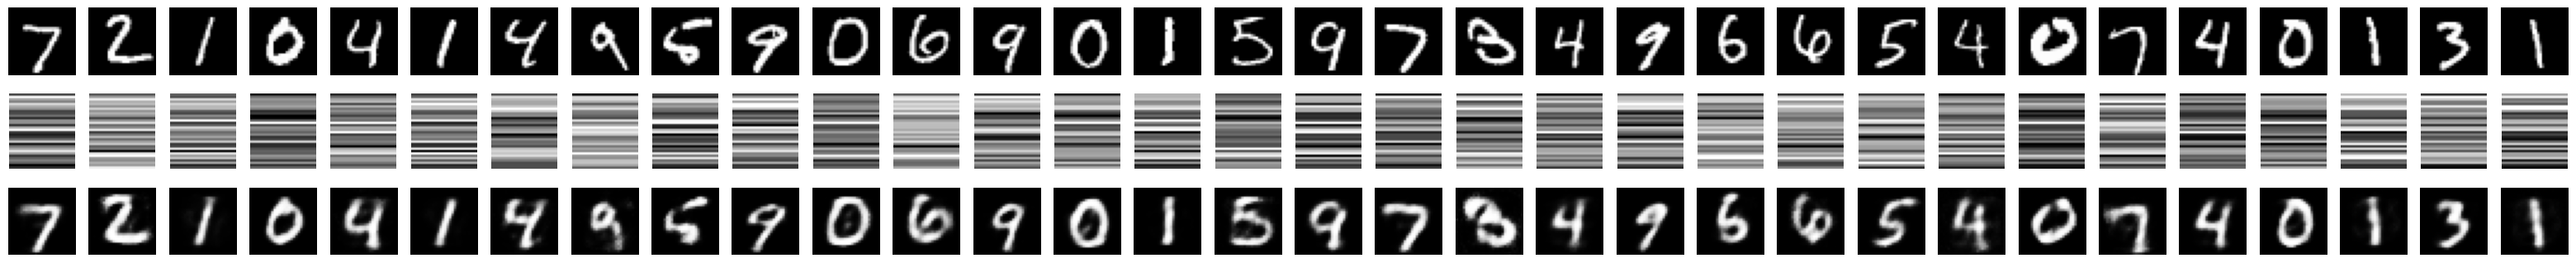

In [ ]:
import keras
from keras import layers
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from keras.utils import Sequence
from skimage.io import imread
import math
from sklearn.model_selection import train_test_split
from skimage.transform import resize
from scipy.stats import entropy
#tf.compat.v1.enable_eager_execution()

# https://www.tensorflow.org/datasets/catalog/
DATASET = 'mnist'
#DATASET = 'fashion_mnist'
#URL = "https://github.com/zalandoresearch/fashion-mnist/blob/master/data/fashion/train-images-idx3-ubyte.gz"

LATENT_SPACE_LENGTH = 32

img_width = 28
img_height = 28
img_length = img_height * img_width

# Generate the NumPy arrays with the data.
DATA_URL = f'https://storage.googleapis.com/tensorflow/tf-keras-datasets/{DATASET}.npz'
path = tf.keras.utils.get_file(f'{DATASET}.npz', DATA_URL)
with np.load(path) as data:
    x_train = data['x_train']
    y_train = data['x_train']
    x_test = data['x_test']
    y_test = data['x_test']

# Generate the pipelines.
train_DS = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_DS = tf.data.Dataset.from_tensor_slices((x_test, y_test))

# Define how to use the datasets, preprocess, etc.

def process_x(image, label):
    processed_img = tf.reshape(image, (img_height * img_width, 1))
    processed_img = tf.cast(processed_img, tf.float32) / 255.
    return processed_img, label

def process_y(image, label):
    # The last layer of the network is a dense layer and TensorFlow imposes 1D.
    return image, tf.reshape(image, (img_height * img_width, 1))

BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 100
train_DS = train_DS.map(process_x)
train_DS = train_DS.map(process_y)
train_DS = train_DS.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_DS = test_DS.map(process_x)
test_DS = test_DS.map(process_y)
test_DS = test_DS.batch(BATCH_SIZE)

class NoisyDense(keras.layers.Layer):

    def __init__(self, units=32, input_dim=32, activation="relu", **kwargs):
        super(NoisyDense, self).__init__(**kwargs)
        w_init = tf.random_normal_initializer()
        self.w = tf.Variable(
            initial_value=w_init(shape=(input_dim, units), dtype="float32"),
            trainable=True,
        )
        b_init = tf.zeros_initializer()
        self.b = tf.Variable(
            initial_value=b_init(shape=(units,), dtype="float32"), trainable=True
        )
        self.quantized_vals = 0

    #@tf.function
    def call(self, inputs):
        outputs = tf.matmul(inputs, self.w) + self.b
        noise = tf.random.uniform(shape=tf.shape(outputs), minval=-.5, maxval=.5)
        #quantized_sums_01 = weighted_sums
        outputs += noise
        #print(tf.reduce_max(weighted_sums))
        #outputs = tf.keras.activations.tanh(outputs)
        #outputs = tf.saturate_cast(tf.round(outputs * 255.), tf.int16)
        #quantized_sums_8b = tf.saturate_cast(tf.round(weighted_sums * 255.), tf.int16)
        self.quantized_vals = outputs
        #print(len(self.quantized_vals))
        #outputs = tf.cast(outputs, tf.float32) / 255.0
        #activations = tf.keras.activations.relu(quantized_sums_01)
        #activations = quantized_sums_01
        #print(len(activations))
        #tf.print(activations)
        #print(type(activations))
        #print("act[0][0] =",activations[0][0])
        #print(activations.numpy())
        #activations_entropy = entropy(tf.make_ndarray(activations), base=2)
        #self.codestream_length = activations_entropy * tf.size(activations)
        return outputs

    def get_vals(self):
        return self.quantized_vals

# Define the autoencoder.
input_layer = keras.Input(
    shape=(img_length,),
    name="inputs")
hidden_layer = NoisyDense(
    units=LATENT_SPACE_LENGTH,
    input_dim = img_length,
    activation="relu",
    name="hidden"
    )(input_layer)
output_layer = layers.Dense(
    img_length,
    activation="sigmoid",
    name="outputs")(hidden_layer)

autoencoder = keras.Model(
    input_layer,
    output_layer)

# To see the latents (content of the hidden layer), we define a new "model" with only the encoder.
encoder = keras.Model(
    input_layer,
    hidden_layer)

autoencoder.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss="binary_crossentropy", run_eagerly=True
)

autoencoder.summary()

# Train.
EPOCHS = 1
ITERATIONS = 1
plt.gray()
for i in range(ITERATIONS):

    autoencoder.fit(
        train_DS,
        epochs=EPOCHS,
        validation_data=test_DS)

    batch_vals = autoencoder.get_layer("hidden").get_vals()
    print("batch_vals =", batch_vals)
    for j in range(BATCH_SIZE):
        try:
            vals = batch_vals[j].numpy() + 512
            print(entropy(vals, base=2))
        except:
            pass
        #print(vals)

    #print("2", autoencoder.get_layer("hidden").variables[1])

    # Show the learning.
    plt.figure(figsize=(40,4))

    n = len(train_DS)
    if n > 32:
        n = 32

    # Show the originals (using the pipeline).
    for images in test_DS.take(1):
        for i in range(n):
            ax = plt.subplot(3, n, i + 1)
            try:
                image = images[0][i].numpy()
                image *= 255
                image = image.astype("uint8").reshape(img_height, img_width)
                plt.imshow(image)
                #plt.gray()
                plt.axis("off")
            except:
                pass

    # See the latent space (as images).
    latent_imgs = encoder.predict(test_DS)
    print("type latent", type(latent_imgs))
    for i in range(n):
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(resize(latent_imgs[i],(LATENT_SPACE_LENGTH, img_width)))
        plt.axis("off")

    # See the reconstructions.
    reconstructed_imgs = autoencoder.predict(test_DS)
    print(type(reconstructed_imgs))
    for i in range(n):
        ax = plt.subplot(3, n, i + 1 + 2*n)
        plt.imshow(reconstructed_imgs[i].reshape(img_height, img_width))
        plt.axis("off")

    plt.show()

In [ ]:
import keras
from keras import layers
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from keras.utils import Sequence
from skimage.io import imread
import math
from sklearn.model_selection import train_test_split
from skimage.transform import resize
import tensorflow_compression as tfc

# https://www.tensorflow.org/datasets/catalog/
DATASET = 'mnist'
#DATASET = 'fashion_mnist'
#URL = "https://github.com/zalandoresearch/fashion-mnist/blob/master/data/fashion/train-images-idx3-ubyte.gz"

LATENT_LENGTH = 32

img_width = 28
img_height = 28
img_length = img_height * img_width

training_DS, test_DS = tfds.load(
    "mnist",
    split=["train", "test"],
    shuffle_files=True,
    as_supervised=True,
    with_info=False,
)

# Define the autoencoder.
def analyze(latent_length):
  return tf.keras.Sequential([
      tf.keras.layers.Conv2D(
          20, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2D(
          50, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_2"),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(
          img_length, use_bias=True, activation="leaky_relu", name="fc_1"),
      tf.keras.layers.Dense(
          latent_length, use_bias=True, activation=None, name="fc_2"),
  ], name="analysis_transform")

def synthesize():
  return tf.keras.Sequential([
      tf.keras.layers.Dense(
          500, use_bias=True, activation="leaky_relu", name="fc_1"),
      tf.keras.layers.Dense(
          2450, use_bias=True, activation="leaky_relu", name="fc_2"),
      tf.keras.layers.Reshape((7, 7, 50)),
      tf.keras.layers.Conv2DTranspose(
          20, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2DTranspose(
          1, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_2"),
  ], name="synthesis_transform")

class MNISTCompressionTrainer(tf.keras.Model):
  """Model that trains a compressor/decompressor for MNIST."""

  def __init__(self, latent_dims):
    super().__init__()
    self.analysis_transform = analyze(latent_dims)
    self.synthesis_transform = synthesize()
    self.prior_log_scales = tf.Variable(tf.zeros((latent_dims,)))

  @property
  def prior(self):
    return tfc.NoisyLogistic(loc=0., scale=tf.exp(self.prior_log_scales))

  def call(self, x, training):
    """Computes rate and distortion losses."""
    # Ensure inputs are floats in the range (0, 1).
    x = tf.cast(x, self.compute_dtype) / 255.
    x = tf.reshape(x, (-1, 28, 28, 1))

    # Compute latent space representation y, perturb it and model its entropy,
    # then compute the reconstructed pixel-level representation x_hat.
    y = self.analysis_transform(x)
    entropy_model = tfc.ContinuousBatchedEntropyModel(
        self.prior, coding_rank=1, compression=False)
    y_tilde, rate = entropy_model(y, training=training)
    x_tilde = self.synthesis_transform(y_tilde)

    # Average number of bits per MNIST digit.
    rate = tf.reduce_mean(rate)

    # Mean absolute difference across pixels.
    distortion = tf.reduce_mean(abs(x - x_tilde))

    return dict(rate=rate, distortion=distortion)

def pass_through_loss(_, x):
  # Since rate and distortion are unsupervised, the loss doesn't need a target.
  return x

def make_mnist_compression_trainer(lmbda, latent_dims=50):
  trainer = MNISTCompressionTrainer(latent_dims)
  trainer.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    # Just pass through rate and distortion as losses/metrics.
    loss=dict(rate=pass_through_loss, distortion=pass_through_loss),
    metrics=dict(rate=pass_through_loss, distortion=pass_through_loss),
    loss_weights=dict(rate=1., distortion=lmbda),
  )
  return trainer

def add_rd_targets(image, label):
  # Training is unsupervised, so labels aren't necessary here. However, we
  # need to add "dummy" targets for rate and distortion.
  return image, dict(rate=0., distortion=0.)

def train_mnist_model(lmbda):
  trainer = make_mnist_compression_trainer(lmbda)
  trainer.fit(
      training_DS.map(add_rd_targets).batch(128).prefetch(8),
      epochs=1,
      validation_data=test_DS.map(add_rd_targets).batch(128).cache(),
      validation_freq=1,
      verbose=1,
  )
  return trainer

trainer = train_mnist_model(lmbda=2000)
trainer.summary()

class MNISTCompressor(tf.keras.Model):
  """Compresses MNIST images to strings."""

  def __init__(self, analysis_transform, entropy_model):
    super().__init__()
    self.analysis_transform = analysis_transform
    self.entropy_model = entropy_model

  def call(self, x):
    # Ensure inputs are floats in the range (0, 1).
    x = tf.cast(x, self.compute_dtype) / 255.
    y = self.analysis_transform(x)
    # Also return the exact information content of each digit.
    _, bits = self.entropy_model(y, training=False)
    return self.entropy_model.compress(y), bits

class MNISTDecompressor(tf.keras.Model):
  """Decompresses MNIST images from strings."""

  def __init__(self, entropy_model, synthesis_transform):
    super().__init__()
    self.entropy_model = entropy_model
    self.synthesis_transform = synthesis_transform

  def call(self, string):
    y_hat = self.entropy_model.decompress(string, ())
    x_hat = self.synthesis_transform(y_hat)
    # Scale and cast back to 8-bit integer.
    return tf.saturate_cast(tf.round(x_hat * 255.), tf.uint8)

def make_mnist_codec(trainer, **kwargs):
  # The entropy model must be created with `compression=True` and the same
  # instance must be shared between compressor and decompressor.
  entropy_model = tfc.ContinuousBatchedEntropyModel(
      trainer.prior, coding_rank=1, compression=True, **kwargs)
  compressor = MNISTCompressor(trainer.analysis_transform, entropy_model)
  decompressor = MNISTDecompressor(entropy_model, trainer.synthesis_transform)
  return compressor, decompressor

compressor, decompressor = make_mnist_codec(trainer)

(originals, _), = test_DS.batch(16).skip(3).take(1)
strings, entropies = compressor(originals)

print(f"String representation of first digit in hexadecimal: 0x{strings[0].numpy().hex()}")
print(f"Number of bits actually needed to represent it: {entropies[0]:0.2f}")
reconstructions = decompressor(strings)
print(type(reconstructions))


def display_digits(originals, strings, entropies, reconstructions):
  """Visualizes 16 digits together with their reconstructions."""
  fig, axes = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(12.5, 5))
  axes = axes.ravel()
  for i in range(len(axes)):
    image = tf.concat([
        tf.squeeze(originals[i]),
        tf.zeros((28, 14), tf.uint8),
        tf.squeeze(reconstructions[i]),
    ], 1)
    axes[i].imshow(image)
    axes[i].text(
        .5, .5, f"→ 0x{strings[i].numpy().hex()} →\n{entropies[i]:0.2f} bits",
        ha="center", va="top", color="white", fontsize="small",
        transform=axes[i].transAxes)
    axes[i].axis("off")
  plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)

#display_digits(originals, strings, entropies, reconstructions)

#input()

# Show the learning.
plt.figure(figsize=(40,4))

n = len(originals)
if n > 32:
    n = 32

# Show the originals (using the pipeline).
for i in range(n):
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(originals[i])
    plt.axis("off")

# See the latent space (as images).
#latent_imgs = encoder.predict(test_DS)
#for i in range(n):
#    ax = plt.subplot(3, n, i + 1 + n)
#    plt.imshow(resize(latent_imgs[i],(LATENT_SPACE_LENGTH, img_width)))
#    plt.axis("off")

# See the reconstructions.
for i in range(n):
    ax = plt.subplot(3, n, i + 1 + 1*n)
    plt.imshow(reconstructions[i])
    plt.axis("off")

plt.show()

ModuleNotFoundError: ignored

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_compression as tfc
import tensorflow_datasets as tfds

In [ ]:
while True:
    time.sleep(1)

In [ ]:
import keras
from keras import layers
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from keras.utils import Sequence
from skimage.io import imread
import math
from sklearn.model_selection import train_test_split
from skimage.transform import resize

LATENT_SPACE_LENGTH = 32

# https://www.tensorflow.org/datasets/catalog/
DATASET = 'mnist'
#DATASET = 'fashion_mnist'
#URL = "https://github.com/zalandoresearch/fashion-mnist/blob/master/data/fashion/train-images-idx3-ubyte.gz"

img_width = 28
img_height = 28
img_length = img_height * img_width

# Generate the NumPy arrays with the data.
DATA_URL = f'https://storage.googleapis.com/tensorflow/tf-keras-datasets/{DATASET}.npz'
path = tf.keras.utils.get_file(f'{DATASET}.npz', DATA_URL)
with np.load(path) as data:
    train_examples = data['x_train']
    train_labels = data['y_train']
    test_examples = data['x_test']
    test_labels = data['y_test']

print(type(train_examples), type(train_labels))
print(len(train_examples), len(test_labels))

# Generate the pipelines.
train_DS = tf.data.Dataset.from_tensor_slices((train_examples, train_labels))
test_DS = tf.data.Dataset.from_tensor_slices((test_examples, test_labels))

print(type(train_DS))

# Define how to use the datasets, preprocess, etc.

def normalize_img(image, label):
    processed_img = tf.cast(image, tf.float32) / 255.
    print(processed_img.shape)
    return processed_img, label

def get_image(image, label):
    return image, tf.reshape(image, (img_height * img_width, 1))

BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100
train_DS = train_DS.map(normalize_img)
train_DS = train_DS.map(get_image)
train_DS = train_DS.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_DS = test_DS.map(normalize_img)
test_DS = test_DS.map(get_image)
test_DS = test_DS.batch(BATCH_SIZE)

# Define the autoencoder.
img_pixels = img_height * img_width
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(img_height, img_width)),
  tf.keras.layers.Dense(LATENT_SPACE_LENGTH, activation='relu'),
  tf.keras.layers.Dense(img_pixels, activation="sigmoid"),
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss="binary_crossentropy"
)

model.summary()

# Train.
EPOCHS = 1
ITERATIONS = 5
for i in range(ITERATIONS):

    model.fit(
        train_DS,
        epochs=EPOCHS,
        validation_data=test_DS)

    # Predict.
    reconstructed_imgs = model.predict(test_DS)

    # Show the predictions.
    plt.figure(figsize=(40,4))

    n = len(train_DS)
    if n > 32:
        n = 32

    ## original
    for images in test_DS.take(1):
        for i in range(n):
            ax = plt.subplot(2, n, i + 1)
            try:
                image = images[0][i].numpy()
                image *= 255
                image = image.astype("uint8").reshape(img_height, img_width)
                plt.imshow(image)
                plt.gray()
                plt.axis("off")
            except:
                pass

    # latent (as an image)
    '''
    for i in range(n):
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(resize(latents[i],(HIDDEN_SIZE, img_width)))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    '''

    ## reconstruction
    for i in range(n):
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructed_imgs[i].reshape(img_height, img_width))
        plt.gray()
        plt.axis("off")

    plt.show()

## Using 3 hidden layer

    Input -> hidden_0 -> latent -> hidden_1 -> Output
    28x28    10x10       32        10x10       28x28

## Ignore the rest

In [ ]:
# Autoencoding example (feeding pipeline (tf.data.Dataset) with NumPy arrays)

import keras
from keras import layers
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from keras.utils import Sequence
from skimage.io import imread
import math
from sklearn.model_selection import train_test_split
from skimage.transform import resize

# Generate the NumPy arrays with the data.
DATA_URL = 'https://storage.googleapis.com/tensorflow/tf-keras-datasets/mnist.npz'
path = tf.keras.utils.get_file('mnist.npz', DATA_URL)
with np.load(path) as data:
    train_examples = data['x_train']
    train_labels = data['y_train']
    test_examples = data['x_test']
    test_labels = data['y_test']

print(type(train_examples), type(train_labels))
print(len(train_examples), len(test_labels))

# Generate the pipelines.
train_DS = tf.data.Dataset.from_tensor_slices((train_examples, train_labels))
test_DS = tf.data.Dataset.from_tensor_slices((test_examples, test_labels))

print(type(train_DS))

# Define how to use the datasets, preprocess, etc.

def normalize_img(image, label):
    processed_img = tf.cast(image, tf.float32) / 255.
    print(processed_img.shape)
    return processed_img, label

def get_image(image, label):
    return image, tf.reshape(image, (28*28, 1))

BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100
train_DS = train_DS.map(normalize_img)
train_DS = train_DS.map(get_image)
train_DS = train_DS.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_DS = test_DS.map(normalize_img)
test_DS = test_DS.map(get_image)
test_DS = test_DS.batch(BATCH_SIZE)

# Define the autoencoder.
img_pixels = 28*28
HIDDEN_SIZE = 32
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(HIDDEN_SIZE, activation='relu'),
  tf.keras.layers.Dense(img_pixels, activation="sigmoid"),
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss="binary_crossentropy"
)

model.summary()

# Train.
EPOCHS = 10
model.fit(
    train_DS,
    epochs=EPOCHS,
    validation_data=test_DS)

# Predict.
reconstructed_imgs = model.predict(test_DS)

# Show the predictions.
img_width = 28
img_height = 28
plt.figure(figsize=(40,4))

n = len(train_DS)
if n > 32:
    n = 32

## original
for images in test_DS.take(1):
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        try:
            image = images[0][i].numpy()
            image *= 255
            image = image.astype("uint8").reshape(img_height, img_width)
            plt.imshow(image)
            plt.gray()
            plt.axis("off")
        except:
            pass

## reconstruction
for i in range(n):
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed_imgs[i].reshape(img_height, img_width))
    plt.gray()
    plt.axis("off")

plt.show()

In [ ]:
!pip install -q tensorflow-datasets
#!pip install tfds-nightly

In [ ]:
import keras
from keras import layers
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from keras.utils import Sequence
from skimage.io import imread
import math
from sklearn.model_selection import train_test_split

In [ ]:
EPOCHS = 10
BATCH_SIZE = 64


# Configure the size of the hidden layer.
HIDDEN_SIZE = 32

In [ ]:
# Load the datasets (notice that we will use x_train = y_train and x_test = y_test)
(x_train, _), (x_test, _) = mnist.load_data()
print(x_train.shape, x_test.shape, type(x_train))

In [ ]:
# Gray-scale images ranges betwen [0, 255]. Neurons must work with values between [0, 1]
x_train = x_train.astype("float32") / 255.
x_test = x_test.astype("float32") / 255.

In [ ]:
img_height = x_train[0].shape[0]
img_width = x_train[0].shape[1]
img_pixels = img_width*img_height
print("The shape of the images is:", img_height, "x", img_width)

In [ ]:
# Our layers will be 1D. The images must be reshaped.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape, x_test.shape)

In [ ]:
# Define the network (2 layers), connecting them sequentially:
# flatten(input_image, 28*28) -> hidden_layer(HIDDEN_SIZE) -> output_layer(28*28)
input_layer = keras.Input(shape=(img_pixels,))
hidden_layer = layers.Dense(HIDDEN_SIZE, activation="relu")(input_layer)
output_layer = layers.Dense(img_pixels, activation="sigmoid")(hidden_layer)
autoencoder = keras.Model(input_layer, output_layer)

In [ ]:
# Compile the network.
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")

In [ ]:
autoencoder.summary()

In [ ]:
# Train the network.
autoencoder.fit(x=x_train, y=x_train,
                epochs=EPOCHS, batch_size=BATCH_SIZE, shuffle=True,
                validation_data=(x_test, x_test))

In [ ]:
# Apply the autoencoder to the test dataset.
reconstructed_imgs = autoencoder.predict(x_test)

In [ ]:
# Show some reconstructions.
n = 10
plt.figure(figsize=(40,4))
for i in range(n):
  # original
  ax = plt.subplot(2, n, i+1)
  plt.imshow(x_test[i].reshape(img_height, img_width))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # reconstruction
  ax = plt.subplot(2, n, i+1+n)
  plt.imshow(reconstructed_imgs[i].reshape(img_height, img_width))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
# To see the latents (content of the hidden layer), we define a new "model" with only the encoder.
encoder = keras.Model(input_layer, hidden_layer)

In [ ]:
latents = encoder.predict(x_test)

In [ ]:
from skimage.transform import resize
n = 10
plt.figure(figsize=(40,4))
for i in range(n):
  # original
  ax = plt.subplot(2, n, i+1)
  plt.imshow(x_test[i].reshape(img_height, img_width))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # latent (as an image)
  ax = plt.subplot(2, n, i+1+n)
  plt.imshow(resize(latents[i],(HIDDEN_SIZE, img_width)))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

#### Images of any shape and the training dataset does not fit in memory

In [ ]:
!pip install -q tensorflow-datasets
#!pip install tfds-nightly

In [ ]:
import keras
from keras import layers
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from keras.utils import Sequence
from skimage.io import imread
import math
from sklearn.model_selection import train_test_split

In [ ]:
# Show available datasets in TensorFlow.
#tfds.list_builders()

In [ ]:
EPOCHS = 10
BATCH_SIZE = 64 # -1 -> All the dataset in memory!

# https://www.tensorflow.org/datasets/catalog/
DATASET = 'clic'  # 7.48 GiB :-()

In [ ]:
train_DS = tfds.load(
    name=DATASET,
    split='train',
    batch_size=BATCH_SIZE,
    shuffle_files=True) # During training, it's important to shuffle the data well - poorly shuffled data can result in lower training accuracy (https://www.tensorflow.org/datasets/performances).

test_DS = tfds.load(
    name=DATASET,
    split="test",
    batch_size=BATCH_SIZE)

In [ ]:
#....

In [ ]:
train_DS

In [ ]:
# Clustering example

import keras
from keras import layers
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from keras.utils import Sequence
from skimage.io import imread
import math
from sklearn.model_selection import train_test_split
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

print(ds_train, len(ds_train))

def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  #print(image)
  return tf.cast(image, tf.float32) / 255., label

ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(32)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)
print(ds_train, len(ds_train))

ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(32)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(28*28)
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

model.summary()

model.fit(
    ds_train,
    epochs=6,
    validation_data=ds_test,
)

reconstructed_imgs = model.predict(ds_test)
# Show some reconstructions.
n = 10

img_width = 28
img_height = 28

plt.figure(figsize=(40,4))
for i in range(n):
  # original
  ax = plt.subplot(2, n, i+1)
  #plt.imshow(np.squeeze(ds_test)[i].reshape(img_height, img_width))
  plt.imshow(reconstructed_imgs[i].reshape(img_height, img_width))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # reconstruction
  ax = plt.subplot(2, n, i+1+n)
  plt.imshow(reconstructed_imgs[i].reshape(img_height, img_width))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
# Autoencoding example (using a data pipeline)

import keras
from keras import layers
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from keras.utils import Sequence
from skimage.io import imread
import math
from sklearn.model_selection import train_test_split

(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True, # Images are labeled
    with_info=True
)
print(ds_train, len(ds_train))

def normalize_img2(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    #print(image['image'].shape)
    #print(image)
    #return image, label
    return tf.cast(image, tf.float32) / 255., label

def get_image(image, label):
    return image, tf.reshape(image, (28*28, 1))

ds_train = ds_train.map(
    normalize_img2, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.map(get_image, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(32)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)
#ds_train = ds_train.map(lambda x: x[0])

print(ds_train, len(ds_train))

ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.map(get_image, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(32)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)
#ds_test = ds_test.map(lambda x: x[0], ds_test)

print(ds_test, len(ds_test))

#x_test = list(map(lambda x: x[0], ds_test))
# = ds_test["image"]

img_pixels = 28*28

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(HIDDEN_SIZE, activation='relu'),
  tf.keras.layers.Dense(img_pixels, activation="sigmoid"),
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss="binary_crossentropy"
)

model.summary()

model.fit(
    ds_train,
    epochs=EPOCHS,
    validation_data=ds_test)

reconstructed_imgs = model.predict(ds_test)

n = 10
plt.figure(figsize=(40,4))

# original
for images in ds_test.take(1):
    print(len(images))
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        image = images[0][i].numpy()
        image *= 255
        image = image.astype("uint8").reshape(28, 28)
        plt.imshow(image)
        plt.gray()
        plt.axis("off")

# reconstruction
for i in range(n):
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(reconstructed_imgs[i].reshape(img_height, img_width))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.show()

In [ ]:
# Autoencoding example (iterative)

import keras
from keras import layers
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from keras.utils import Sequence
from skimage.io import imread
import math
from sklearn.model_selection import train_test_split

img_pixels = 28*28
HIDDEN_SIZE = 32
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(HIDDEN_SIZE, activation='relu'),
  tf.keras.layers.Dense(img_pixels, activation="sigmoid"),
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss="binary_crossentropy"
)

model.summary()

def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  #print(image)
  return tf.cast(image, tf.float32) / 255., label

def get_image(image, label):
    return image, tf.reshape(image, (28*28, 1))

img_width = 28
img_height = 28
ITERATIONS = 20
for i in range(ITERATIONS):

    (ds_train, ds_test), ds_info = tfds.load(
        'mnist',
        split=['train', 'test'],
        shuffle_files=True,
        as_supervised=True, # Images are labeled
        with_info=True)

    ds_train = ds_train.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
    ds_train = ds_train.map(get_image, num_parallel_calls=tf.data.AUTOTUNE)
    ds_train = ds_train.cache()
    ds_train = ds_train.shuffle(
        ds_info.splits['train'].num_examples,
        reshuffle_each_iteration=True)
    ds_train = ds_train.batch(32)
    ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

    ds_test = ds_test.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
    ds_test = ds_test.map(get_image, num_parallel_calls=tf.data.AUTOTUNE)
    ds_test = ds_test.batch(32)
    ds_test = ds_test.cache()
    #ds_test = ds_test.shuffle(ds_info.splits['test[:10%]'].num_examples,
    #    reshuffle_each_iteration=True)
    ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

    print("len(train_DS) =", len(ds_train))
    print("len(test_DS) =", len(ds_test))

    n = len(ds_train)
    if n > 10:
        n = 10
    for images in ds_train.take(1):
        print(len(images))
        for i in range(min(len(ds_train), n)):
            ax = plt.subplot(2, n, i + 1)
            try:
                image = images[0][i].numpy()
                image *= 255
                image = image.astype("uint8").reshape(img_height, img_width)
                plt.imshow(image)
                plt.gray()
                plt.axis("off")
            except:
                pass

    EPOCHS = 1
    model.fit(
        ds_train,
        epochs=EPOCHS,
        validation_data=ds_test)

    reconstructed_imgs = model.predict(ds_test)

    plt.figure(figsize=(40,4))
    #plt.figure()

    # original
    for images in ds_test.take(1):
        #print(len(images))
        for i in range(n):
            ax = plt.subplot(2, n, i + 1)
            try:
                image = images[0][i].numpy()
                image *= 255
                image = image.astype("uint8").reshape(img_height, img_width)
                plt.imshow(image)
                plt.gray()
                plt.axis("off")
            except:
                pass

    # reconstruction
    for i in range(n):
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructed_imgs[i].reshape(img_height, img_width))
        plt.gray()
        #ax.get_xaxis().set_visible(False)
        #ax.get_yaxis().set_visible(False)
        plt.axis("off")

    plt.show()

In [ ]:
# Autoencoding example (iterative, minimal)

import keras
from keras import layers
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from keras.utils import Sequence
from skimage.io import imread
import math
from sklearn.model_selection import train_test_split

img_pixels = 28*28
HIDDEN_SIZE = 32
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(HIDDEN_SIZE, activation='relu'),
  tf.keras.layers.Dense(img_pixels, activation="sigmoid"),
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss="binary_crossentropy"
)

model.summary()

def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  #print(image)
  return tf.cast(image, tf.float32) / 255., label

def get_image(image, label):
    return image, tf.reshape(image, (28*28, 1))

img_width = 28
img_height = 28
ITERATIONS = 20
for i in range(ITERATIONS):

    (ds_train, ds_test), ds_info = tfds.load(
        'mnist',
        split=['train[:1000]', 'test'],
        shuffle_files=True,
        as_supervised=True, # Images are labeled
        with_info=True)

    ds_train = ds_train.map(normalize_img)
    ds_train = ds_train.map(get_image)
    ds_train = ds_train.cache() # Do not put me in the last position
    ds_train = ds_train.shuffle(
        ds_info.splits['train'].num_examples,
        reshuffle_each_iteration=True)
    ds_train = ds_train.batch(32)

    ds_test = ds_test.map(normalize_img)
    ds_test = ds_test.map(get_image)
    ds_test = ds_test.shuffle(
        ds_info.splits['test'].num_examples,
        reshuffle_each_iteration=True)
    ds_test = ds_test.batch(32)
    ds_test = ds_test.cache() # Put me in the last position

    print("len(train_DS) =", len(ds_train))
    print("len(test_DS) =", len(ds_test))

    n = len(ds_train)
    if n > 32:
        n = 32

    plt.figure(figsize=(40,2))

    for images in ds_train.take(1):
        print(len(images))
        for i in range(min(len(ds_train), n)):
            ax = plt.subplot(1, n, i + 1)
            try:
                image = images[0][i].numpy()
                image *= 255
                image = image.astype("uint8").reshape(img_height, img_width)
                plt.imshow(image)
                plt.gray()
                plt.axis("off")
            except:
                pass

    EPOCHS = 1
    model.fit(
        ds_train,
        epochs=EPOCHS,
        validation_data=ds_test)

    reconstructed_imgs = model.predict(ds_test)

    plt.figure(figsize=(40,4))

    # original
    for images in ds_test.take(1):
        for i in range(n):
            ax = plt.subplot(2, n, i + 1)
            try:
                image = images[0][i].numpy()
                image *= 255
                image = image.astype("uint8").reshape(img_height, img_width)
                plt.imshow(image)
                plt.gray()
                plt.axis("off")
            except:
                pass

    # reconstruction
    for i in range(n):
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructed_imgs[i].reshape(img_height, img_width))
        plt.gray()
        plt.axis("off")

    plt.show()

In [ ]:
# Autoencoding example (iterative, minimal, clic) FREEZES :-(

import keras
from keras import layers
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from keras.utils import Sequence
from skimage.io import imread
import math
from sklearn.model_selection import train_test_split

img_pixels = 28*28
HIDDEN_SIZE = 32
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(HIDDEN_SIZE, activation='relu'),
  tf.keras.layers.Dense(img_pixels, activation="sigmoid"),
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss="binary_crossentropy"
)

model.summary()

def normalize_img(image):
    #print(type(image['image']))
    processed_img = tf.cast(image['image'], tf.float32) / 255.
    #print(processed_img.get_shape().as_list(), processed_img.dtype)
    processed_img = tf.image.resize(processed_img, [28, 28])
    if processed_img.get_shape().as_list()[2] > 1:
        processed_img = tf.image.rgb_to_grayscale(processed_img)
    #print(processed_img.get_shape().as_list(), processed_img.dtype)
    return processed_img

def get_image(image):
    return image, tf.reshape(image, (28*28, 1))

img_width = 28
img_height = 28
ITERATIONS = 20
for i in range(ITERATIONS):

    (ds_train, ds_test), ds_info = tfds.load(
        'clic',
        split=['train[:32]', 'test[:32]'],
        shuffle_files=True,
        #as_supervised=True, # Images are labeled
        with_info=True)

    ds_train = ds_train.map(normalize_img)
    ds_train = ds_train.map(get_image)
    ds_train = ds_train.cache() # Do not put me in the last position
    ds_train = ds_train.shuffle(
        ds_info.splits['train'].num_examples,
        reshuffle_each_iteration=True)
    ds_train = ds_train.batch(32)

    ds_test = ds_test.map(normalize_img)
    ds_test = ds_test.map(get_image)
    ds_test = ds_test.shuffle(
        ds_info.splits['test'].num_examples,
        reshuffle_each_iteration=True)
    ds_test = ds_test.batch(32)
    ds_test = ds_test.cache() # Put me in the last position

    print("len(train_DS) =", len(ds_train))
    print("len(test_DS) =", len(ds_test))

    n = len(ds_train)
    if n > 32:
        n = 32

    plt.figure(figsize=(40,2))

    for images in ds_train.take(1):
        print(len(images))
        for i in range(min(len(ds_train), n)):
            ax = plt.subplot(1, n, i + 1)
            try:
                image = images[0][i].numpy()
                image *= 255
                image = image.astype("uint8").reshape(img_height, img_width)
                plt.imshow(image)
                plt.gray()
                plt.axis("off")
            except:
                pass

    EPOCHS = 1
    model.fit(
        ds_train,
        epochs=EPOCHS,
        validation_data=ds_test)

    reconstructed_imgs = model.predict(ds_test)

    plt.figure(figsize=(40,4))

    # original
    for images in ds_test.take(1):
        for i in range(n):
            ax = plt.subplot(2, n, i + 1)
            try:
                image = images[0][i].numpy()
                image *= 255
                image = image.astype("uint8").reshape(img_height, img_width)
                plt.imshow(image)
                plt.gray()
                plt.axis("off")
            except:
                pass

    # reconstruction
    for i in range(n):
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructed_imgs[i].reshape(img_height, img_width))
        plt.gray()
        plt.axis("off")

    plt.show()

In [ ]:
# Using clic images (freezes)

import keras
from keras import layers
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from keras.utils import Sequence
from skimage.io import imread
import math
from sklearn.model_selection import train_test_split
import time

HIDDEN_SIZE = 256
img_pixels = 64*64

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(64, 64)),
  tf.keras.layers.Dense(HIDDEN_SIZE, activation='relu'),
  tf.keras.layers.Dense(img_pixels, activation="sigmoid"),
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss="binary_crossentropy"
)

model.summary()

def process_dataset(image):
    #print(type(image['image']))
    processed_img = tf.cast(image['image'], tf.float32) / 255.
    #print(processed_img.get_shape().as_list(), processed_img.dtype)
    processed_img = tf.image.resize(processed_img, [64, 64])
    if processed_img.get_shape().as_list()[2] > 1:
        processed_img = tf.image.rgb_to_grayscale(processed_img)
    #print(processed_img.get_shape().as_list(), processed_img.dtype)
    return processed_img

def define_y(image):
    return image, tf.reshape(image, (64*64, 1))

EPOCHS = 1
ITERATIONS = 100
for i in range(ITERATIONS):
    print("iteration", i)
    (ds_train, ds_test), ds_info = tfds.load(
        'clic',
        split=['train[:128]', 'test[:16]'],
        shuffle_files=True, # Shuffle the files between each epoch.
        with_info=True)

    ds_train = ds_train.map(process_dataset)
    #ds_train = ds_train.map(process_dataset, num_parallel_calls=tf.data.AUTOTUNE)
    ds_train = ds_train.map(define_y)
    #ds_train = ds_train.map(define_y, num_parallel_calls=tf.data.AUTOTUNE)
    #ds_train = ds_train.cache()
    #ds_train = ds_train.shuffle(
    #    ds_info.splits['train'].num_examples,
    #    reshuffle_each_iteration=True)
    ds_train = ds_train.batch(32)
    #ds_train = ds_train.batch(32, drop_remainder=True)
    #ds_train = ds_train.batch(1024, drop_remainder=True)
    #ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

    ds_test = ds_test.map(process_dataset)
    #ds_test = ds_test.map(process_dataset, num_parallel_calls=tf.data.AUTOTUNE)
    ds_test = ds_test.map(define_y)
    #ds_test = ds_test.map(define_y, num_parallel_calls=tf.data.AUTOTUNE)
    ds_test = ds_test.batch(32)
    #ds_test = ds_test.batch(1024, drop_remainder=True)
    #ds_test = ds_test.cache()
    #ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

    model.fit(
        ds_train,
        epochs=EPOCHS,#//10#,
        #shuffle='batch',
        #verbose=2,
        validation_data=ds_test
    )
    #model.save("model")
    #model.load("model")

    reconstructed_imgs = model.predict(ds_test)

    n = 10
    plt.figure(figsize=(40,4))

    # original
    for images in ds_test.take(1):
        print(len(images))
        for i in range(n):
            ax = plt.subplot(2, n, i + 1)
            image = images[0][i].numpy()
            image *= 255
            image = image.astype("uint8").reshape(64, 64)
            plt.imshow(image)
            plt.gray()
            plt.axis("off")

    # reconstruction
    for i in range(n):
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(reconstructed_imgs[i].reshape(64, 64))
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)

    plt.show()


In [ ]:
# Using clic images (save and load)

import keras
from keras import layers
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from keras.utils import Sequence
from skimage.io import imread
import math
from sklearn.model_selection import train_test_split
import time

HIDDEN_SIZE = 256
img_pixels = 64*64

#input_layer = keras.Input(shape=(64*64,))
#hidden_layer = layers.Dense(HIDDEN_SIZE, activation="relu")(input_layer)
#output_layer = layers.Dense(img_pixels, activation="sigmoid")(hidden_layer)
#model = keras.Model(input_layer, output_layer)
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(64, 64)),
  tf.keras.layers.Dense(HIDDEN_SIZE, activation='relu'),
  tf.keras.layers.Dense(img_pixels, activation="sigmoid"),
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss="binary_crossentropy"
)

model.summary()

def process_dataset(image):
    #print(type(image['image']))
    processed_img = tf.cast(image['image'], tf.float32) / 255.
    #print(processed_img.get_shape().as_list(), processed_img.dtype)
    processed_img = tf.image.resize(processed_img, [64, 64])
    if processed_img.get_shape().as_list()[2] > 1:
        processed_img = tf.image.rgb_to_grayscale(processed_img)
    #print(processed_img.get_shape().as_list(), processed_img.dtype)
    #processed_img = tf.image.resize(processed_img, [64*64, 1])
    return processed_img

def define_y(image):
    return image, tf.reshape(image, (64*64, 1))

EPOCHS = 1
ITERATIONS = 100
for i in range(ITERATIONS):
    print("iteration", i)
    (ds_train, ds_test), ds_info = tfds.load(
        'clic',
        split=['train[:128]', 'test[:16]'],
        shuffle_files=True, # Shuffle the files between each epoch.
        with_info=True)

    ds_train = ds_train.map(process_dataset, num_parallel_calls=tf.data.AUTOTUNE)
    ds_train = ds_train.map(define_y, num_parallel_calls=tf.data.AUTOTUNE)
    ds_train = ds_train.cache()
    ds_train = ds_train.shuffle(
        ds_info.splits['train'].num_examples,
        reshuffle_each_iteration=True)
    ds_train = ds_train.batch(32)
    #ds_train = ds_train.batch(1024, drop_remainder=True)
    ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

    ds_test = ds_test.map(process_dataset, num_parallel_calls=tf.data.AUTOTUNE)
    ds_test = ds_test.map(define_y, num_parallel_calls=tf.data.AUTOTUNE)
    ds_test = ds_test.batch(32)
    #ds_test = ds_test.batch(1024, drop_remainder=True)
    ds_test = ds_test.cache()
    ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

    model.fit(
        ds_train,
        epochs=EPOCHS,#//10#,
        #shuffle='batch',
        validation_data=ds_test
    )
    keras.models.save_model(model, "model")

    model = tf.keras.models.Sequential([
      tf.keras.layers.Flatten(input_shape=(64, 64)),
      tf.keras.layers.Dense(HIDDEN_SIZE, activation='relu'),
      tf.keras.layers.Dense(img_pixels, activation="sigmoid"),
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(0.001),
        loss="binary_crossentropy"
    )

    model = keras.models.load_model("model")

    #model.load("model")

    reconstructed_imgs = model.predict(ds_test)

    n = 10
    plt.figure(figsize=(40,4))

    # original
    for images in ds_test.take(1):
        print(len(images))
        for i in range(n):
            ax = plt.subplot(2, n, i + 1)
            image = images[0][i].numpy()
            image *= 255
            image = image.astype("uint8").reshape(64, 64)
            plt.imshow(image)
            plt.gray()
            plt.axis("off")

    # reconstruction
    for i in range(n):
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(reconstructed_imgs[i].reshape(64, 64))
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)

    plt.show()


In [ ]:
# Using clic images (using a custom callback to visualize the training dataset after each epoch)

import keras
from keras import layers
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from keras.utils import Sequence
from skimage.io import imread
import math
from sklearn.model_selection import train_test_split
import time

HIDDEN_SIZE = 256
img_pixels = 64*64

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(64, 64)),
  tf.keras.layers.Dense(HIDDEN_SIZE, activation='relu'),
  tf.keras.layers.Dense(img_pixels, activation="sigmoid"),
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss="binary_crossentropy"
)

model.summary()

def process_dataset(image):
    #print(type(image['image']))
    processed_img = tf.cast(image['image'], tf.float32) / 255.
    #print(processed_img.get_shape().as_list(), processed_img.dtype)
    processed_img = tf.image.resize(processed_img, [64, 64])
    if processed_img.get_shape().as_list()[2] > 1:
        processed_img = tf.image.rgb_to_grayscale(processed_img)
    #print(processed_img.get_shape().as_list(), processed_img.dtype)
    return processed_img

def define_y(image):
    return image, tf.reshape(image, (64*64, 1))

EPOCHS = 100

def load_data():
    (ds_train, ds_test), ds_info = tfds.load(
        'clic',
        split=['train[:10]', 'test[:10]'],
        shuffle_files=True, # Shuffle the files between each epoch.
        with_info=True)

    ds_train = ds_train.map(process_dataset, num_parallel_calls=tf.data.AUTOTUNE)
    ds_train = ds_train.map(define_y, num_parallel_calls=tf.data.AUTOTUNE)
    ds_train = ds_train.cache()
    ds_train = ds_train.shuffle(
        ds_info.splits['train'].num_examples,
        reshuffle_each_iteration=True)
    ds_train = ds_train.batch(10)
    #ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

    n = 10
    for images in ds_train.take(1):
        print(len(images))
        for i in range(n):
            ax = plt.subplot(2, n, i + 1)
            image = images[0][i].numpy()
            image *= 255
            image = image.astype("uint8").reshape(64, 64)
            plt.imshow(image)
            plt.gray()
            plt.axis("off")
    plt.show()

    ds_test = ds_test.map(process_dataset, num_parallel_calls=tf.data.AUTOTUNE)
    ds_test = ds_test.map(define_y, num_parallel_calls=tf.data.AUTOTUNE)
    ds_test = ds_test.batch(10)
    ds_test = ds_test.cache()
    #ds_test = ds_test.prefetch(tf.data.AUTOTUNE)
    return ds_train, ds_test

ds_train, ds_test = load_data()

class CustomCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        load_data()
        keys = list(logs.keys())
        print("End epoch {} of training; got log keys: {}".format(epoch, keys))

model.fit(
    ds_train,
    epochs=EPOCHS,#//10#,
    shuffle='batch',
    validation_data=ds_test,
    callbacks=[CustomCallback()]
)

reconstructed_imgs = model.predict(ds_test)

n = 10
plt.figure(figsize=(40,4))

# original
for images in ds_test.take(1):
    print(len(images))
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        image = images[0][i].numpy()
        image *= 255
        image = image.astype("uint8").reshape(64, 64)
        plt.imshow(image)
        plt.gray()
        plt.axis("off")

# reconstruction
for i in range(n):
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(reconstructed_imgs[i].reshape(64, 64))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.show()


In [ ]:

print(tf.__version__)
(ds_train, ds_test), ds_info = tfds.load(
    'clic',
    split=['train[:4%]', 'test[:1%]'],
    shuffle_files=True,
    with_info=True
)
print(ds_train, len(ds_train))

def process_dataset(image):
    print(type(image['image']))
    processed_img = tf.cast(image['image'], tf.float32) / 255.
    print(processed_img.get_shape().as_list(), processed_img.dtype)
    processed_img = tf.image.resize(processed_img, [64, 64])
    if processed_img.get_shape().as_list()[2] > 1:
        processed_img = tf.image.rgb_to_grayscale(processed_img)
    print(processed_img.get_shape().as_list(), processed_img.dtype)
    return processed_img

def define_y(image):
    return image, tf.reshape(image, (64*64, 1))

#ds_train = ds_train.map(get_image, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.map(process_dataset, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.map(define_y, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(1024)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

plt.figure(figsize=(10, 10))
#class_names = ds_train.class_names

print("take=", ds_train.take(1))

for images in ds_train.take(1):
    print(len(images))
    for i in range(32):
        #print(len(images[i]))
        ax = plt.subplot(6, 6, i + 1)
        # plt.imshow(images[i].numpy().astype("uint8"))
        image = images[0][i].numpy()
        image *= 255
        image = image.astype("uint8").reshape(64,64)
        #print(image.shape)
        plt.imshow(image)
        plt.gray()
        #plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
print(ds_train, len(ds_train))

ds_test = ds_test.map(process_dataset, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.map(define_y, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(1024)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

print(ds_test, len(ds_test))

img_pixels = 64*64

In [ ]:
HIDDEN_SIZE = 256

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(64, 64)),
  tf.keras.layers.Dense(HIDDEN_SIZE, activation='relu'),
  tf.keras.layers.Dense(img_pixels, activation="sigmoid"),
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss="binary_crossentropy"
)

model.summary()

In [ ]:
model.fit(ds_train,
    epochs=EPOCHS,
    validation_data=ds_test)

In [ ]:
reconstructed_imgs = model.predict(ds_test)

In [ ]:
len(reconstructed_imgs)

In [ ]:
reconstructed_imgs

In [ ]:
type(reconstructed_imgs)

In [ ]:
# Show some reconstructions.
n = 4

img_width = 64
img_height = 64

for images in ds_train.take(1):
    print(len(images))
    for i in range(32):
        #print(len(images[i]))
        ax = plt.subplot(6, 6, i + 1)
        # plt.imshow(images[i].numpy().astype("uint8"))
        image = images[0][i].numpy()
        image *= 255
        image = image.astype("uint8").reshape(64,64)
        #print(image.shape)
        plt.imshow(image)
        #plt.title(class_names[labels[i]])
        plt.gray()
        plt.axis("off")

for i in range(n):
  # reconstruction
  ax = plt.subplot(2, n, i+1+n)
  plt.imshow(reconstructed_imgs[i].reshape(img_height, img_width))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

<PrefetchDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))> 60000
<PrefetchDataset element_spec={'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None)}> 163

In [ ]:
64*64

<PrefetchDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
    
<PrefetchDataset element_spec={'image': TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>
    
<PrefetchDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
autoencoder.fit(train_DS, epochs=2)

In [ ]:
def normalize_img(image, label):
  return tf.cast(image, tf.float32) / 255., label
train_DS = train_DS.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [ ]:
# https://www.tensorflow.org/api_docs/python/tf/keras/utils/Sequence
class CLIC_Sequence(Sequence):

    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)#.astype(np.int)

    def get_batch(batch_filenames):
        batch = []
        for filename in batch_filenames:
            image = imread(filename)
            resized_image = resize(image, (200, 200))
            image_01 = resized_image / 255.0
            batch.append(image_01)
        return batch

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]

        image = imread(file_name)
        resized_image = resize(image, (200, 200))
        return np.array(get_batch(batch_x)), np.array(batch_y)

In [ ]:

train_DS = tfds.as_numpy(train_DS)
test_DS = tfds.as_numpy(test_DS)

x_train, y_train = train_DS["image"], train_DS["label"]
x_test, y_test = test_DS["image"], test_DS["label"]

In [ ]:
x_train = x_train.astype("float32") / 255.
x_test = x_test.astype("float32") / 255.

In [ ]:
encoding_dim = 32
img_height = x_train[0].shape[0]
img_width = x_train[0].shape[1]
img_pixels = img_width*img_height
print(img_pixels)

In [ ]:
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [ ]:
print(x_train.shape, x_test.shape)

In [ ]:
input_img = keras.Input(shape=(img_pixels,))
encoded = layers.Dense(encoding_dim, activation="relu")(input_img)
decoded = layers.Dense(img_pixels, activation="sigmoid")(encoded)
autoencoder = keras.Model(input_img, decoded)

In [ ]:
encoder = keras.Model(input_img, encoded)

In [ ]:
encoded_input = keras.Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-1]
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))

In [ ]:
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")

In [ ]:
autoencoder.fit(x_train, x_train, epochs=EPOCHS, batch_size=BATCH_SIZE, shuffle=True, validation_data=(x_test, x_test))

In [ ]:
encoded_imgs = encoder.predict(x_test)

In [ ]:
decoded_imgs = decoder.predict(encoded_imgs)

In [ ]:
import matplotlib.pyplot as plt
n = 10
plt.figure(figsize=(40,4))
for i in range(n):
  # original
  ax = plt.subplot(2, n, i+1)
  plt.imshow(x_test[i].reshape(img_height, img_width))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # reconstruction
  ax = plt.subplot(2, n, i+1+n)
  plt.imshow(decoded_imgs[i].reshape(img_height, img_width))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
def _normalize_img(img, label):
  img = tf.cast(img, tf.float32) / 255.
  return (img, label)

train_DS = tfds.load('mnist', split='train', as_supervised=True)
train_DS = train_DS.batch(32)
train_DS = train_DS.map(_normalize_img)

test_DS = tfds.load('mnist', split='test', as_supervised=True)
test_DS = test_DS.batch(32)
test_DS = test_DS.map(_normalize_img)

#model.fit(ds_train, epochs=5)

In [ ]:
def _normalize_img(img, label):
  img = tf.cast(img, tf.float32) / 255.
  return (img, label)

train_DS = tfds.load('mnist', split='train', as_supervised=True)
train_DS = train_DS.batch(32)
train_DS = train_DS.map(_normalize_img)

test_DS = tfds.load('mnist', split='test', as_supervised=True)
test_DS = test_DS.batch(32)
test_DS = test_DS.map(_normalize_img)

#model.fit(ds_train, epochs=5)

In [ ]:
(train_DS, test_DS), info = tfds.load(name="mnist", split=[tfds.Split.TRAIN,tfds.Split.TEST], with_info=True, as_supervised=True)
train_size = info.splits['train'].num_examples
test_size = info.splits['test'].num_examples
print(train_size, test_size)

def _normalize_img(img, label):
  img = tf.cast(img, tf.float32) / 255.
  return (img, label)

train_DS = train_DS.batch(32)
train_DS = train_DS.map(_normalize_img)
test_DS = test_DS.batch(32)
test_DS = test_DS.map(_normalize_img)